# SPEC9270 ML Assignment <a class="anchor" id="top"></a>

**Simon Hall (D21125776)**

This project is centred around an ongoing [Kaggle](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/overview) competition, and seeks to make a submission to this competition using Machine Learning techniques. In this competition, H&M Group have invited contributors to make product recommendations based on data from previous transactions and from customer and product meta data. The task is to predict twelve product **article_id**s that each customer might purchase during the seven-day period immediately after the two-year transaction data provided. What follows is my very humble attempt to contribute *something* to this competition.

**Strategy**:

I've decided to split the historical transaction data into two timeframes, using the earlier data to generate information about each of the customers and to build an analytical base table, and using the most popular articles purchased by customers in the later data as target labels for model training purposes. In general, this approach was far from perfect, as the models capture information about a specific time period and are not broadly generalisable, but should suffice for the task given that we are predicting purchases over that same limited time frame. In addition, data on some customers will be used during both training and deployment. This is far from ideal, but acceptable in the end given that we are not making a single prediction for each customer, but making twelve purchase predictions in total. In terms of Machine Learning, I originally developed a twin approach. The first approach set out to predict later **article_id** purchases based on previous purchases at the same granularity, **article_id**, as this would certainly capture the most information. Ultimately, this strategy came at too high a computational cost even using Kaggle's public tier or Google Colab. Instead, I sought to predict **article_id** purchases based on previous purchases measured at a coarser grain. However, the pipeline used for this coarse grain data can easily be adapted to the finer grain data given access to more powerful machinery. The second approach sought to aggregate information about each customer based on their previous purchases, engineering features such as favourite colour. Unfortunately, neither model proved to have much predictive power as they were unable to beat a baseline non-personalised prediction for all customers, a simple prediction of the most popular twelve articles from the final week of data (this prediction carried a score of 0.0056 on Kaggle). Ultimately, I decided to combine these approaches into a hybrid model. Happily, the hybrid model works! It is able to beat the baseline score by assigning better individual recommendations to each customer from among the most popular articles.

**FINAL KAGGLE SCORE**: A mediocre 0.0061, but it works!

**TOTAL RUN TIME**: ~ 100 minutes on MacBook Pro (M1 Processor, 8GB).

## Contents:
* [1. Importation & Description](#first-bullet)
    * [i. Articles](#articles-bullet)
    * [ii. Customers](#customers-bullet)
    * [iii. Transactions](#transactions-bullet)
    * [iv. Sample Submission](#submission-bullet)
* [2. Features & Data Exploration](#second-bullet)
    * [i. Articles](#articles2-bullet)
    * [ii. Customers](#customers2-bullet)
    * [iii. Transactions](#transactions2-bullet)
* [3. Missing or Unusual Values](#third-bullet)
    * [Customers](#customers3-bullet)
        * [i. Club Member Status](#cms-bullet)
        * [ii. Fashion News Frequency](#fnf-bullet)
        * [iii. FN](#fn-bullet)
        * [iv. Active](#active-bullet)
        * [v. Age](#age-bullet)
* [4. Feature Selection](#fourth-bullet)
* [5. Splitting the Data and Label Creation](#fifth-bullet)
* [6. Merging DataFrames](#sixth-bullet)
* [7. Machine Learning](#seventh-bullet)
    * [i. Low Grain Purchasing Data](#lgpd-bullet)
    * [ii. Customer Information](#ci-bullet)
    * [iii. Aggregate Descriptive Features](#adf-bullet)
        * [a. Favourite Colour](#colour-bullet)
        * [b. Second Favourite Colour](#2fc-bullet)
        * [c. Favourite Pattern](#fp-bullet)
    * [iv. Binning and Encoding](#bae-bullet)
        * [a. Age Binning](#age2-bullet)
        * [b. One-Hot-Encoding](#ohe-bullet)
        * [c. Ordinal Encoding](#oe-bullet)
    * [v. Analytical Base Table](#abt-bullet)
    * [vi. Balancing the Data](#bd-bullet)
    * [vii. Advanced Feature Selection](#afs-bullet)
    * [viii. kNN Classifier](#knn-bullet)
        * [a. Standardisation](#std-bullet)
        * [b. Model Grid Search](#mgs-bullet)
        * [c. Model Evaluation](#meval-bullet)
        * [d. Decision Tree Comparison](#dt-bullet)
    * [ix. Predictions](#pred-bullet)
    * [x. The 12 Top Articles](#twelve-bullet)
    * [xi. MAP@12 Evaluation](#eval-bullet)    
    * [xii. Deployment](#dep-bullet) 
* [Conclusion](#conc-bullet)
* [References](#references-bullet)

## 1. Importation & Description <a class="anchor" id="first-bullet"></a>

[TOP ↑](#top)

First, we must import the relevant modules and load the relevant data, which is taken from the Kaggle competition. There are three primary datasets to contend with: **articles.csv**, **customers.csv**, and **transactions_train.csv**. The **articles.csv** contains information relating to the articles that are available for sale at H&M, the **customers.csv** file contains information on each customer in the database, while **transactions_train.csv** contains all of the purchases over a two year period from September 2018 to September 2020. The grain of the purchasing data  is per customer per article. There is also a fourth data set provided, **sample_submission.csv**, which contains a sample submission.

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import os

In [4]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils.multiclass import unique_labels

In [5]:
from sklearn.svm import SVC
from random import choices
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

We'll import the **articles.csv** file to a dataframe called **articles_df**. The **article_id** should be imported as a string to preserve the leading zero. 

In [6]:
articles_df = pd.read_csv("../input/articles.csv", dtype={"article_id": str})

We'll import the **customers.csv** file to a dataframe called **customers_df**. The **customer_id** should be imported as a string to preserve the leading zeroes.

In [7]:
customers_df = pd.read_csv("../input/customers.csv", dtype={"customer_id": str})

We'll import the **transactions_train.csv** file to a dataframe called **transactions_df**. We'll also parse the transaction dates (**t_dat**) so that they're imported properly as datetime objects. As before, we import the **article_id** and **customer_id** as strings.

In [8]:
%time transactions_df = pd.read_csv("../input/transactions_train.csv", dtype={"article_id": str, "customer_id": str}, parse_dates=["t_dat"])

CPU times: user 41 s, sys: 3.9 s, total: 44.9 s
Wall time: 46.6 s


The following line of code just samples the transactions for quick testing of the pipeline.

In [9]:
#transactions_df = transactions_df.sample(frac=0.5, replace=False, random_state=1)

Finally, we'll import the **sample_submission.csv** file to a dataframe called **sample_submission_df**.

In [10]:
sample_submission_df = pd.read_csv("../input/sample_submission.csv")

**Optimisation**

Out of concern for the execution time and for the sake of overall optimisation, we'll convert the **article_id** to an integer, and then convert it back to a string prior to submission. This was a good suggestion taken from the Kaggle discussion boards.

In [11]:
articles_df['article_id'] = articles_df['article_id'].astype('int32')
transactions_df['article_id'] = transactions_df['article_id'].astype('int32')

Next, we'll extract some descriptive information from each of these data sets.

### i. Articles <a class="anchor" id="articles-bullet"></a>

[TOP ↑](#top)

First, we can determine the shape of the **articles_df** dataframe. In this case, there are 25 features and 105,542 individual records. There are, therefore, 105,542 items available for sale in the database.

In [12]:
articles_df.shape

(105542, 25)

Next, we can print the head, to get a feel for the dataframe.

In [13]:
pd.set_option('display.max_columns', None)
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


Now, we can pull some information relating to the data, particularly the data types.

In [14]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int32 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

Next, we can count the number of missing values. In this case, there are 416 missing values in the detailed description (**detail_desc**) feature. This feature is not so important for our purposes.

In [15]:
articles_df.isnull().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

Finally, we can count the number of unique values in each feature. This will give us the cardinality.

In [16]:
articles_df.nunique()

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

We can see that there is a discrepancy between the cardinality of several columns which are supposedly equivalent. This is only a small discrepancy when it comes to, for instance, **product_type_name** and **product_type_no**, but it's quite extensive for **product_code** and **prod_name**. We will likely, therefore, concentrate on the numeric columns which have a slightly higher cardinality.

We can take a quick look at what some of this data looks like by printing the unique values in some features of interest. Though these will be explored in detail in [Section 2](#second-bullet).

In [17]:
print(articles_df['product_code'].unique())

[108775 110065 111565 ... 956217 957375 959461]


In [18]:
print(articles_df['prod_name'].unique())

['Strap top' 'Strap top (1)' 'OP T-shirt (Idro)' ... 'Cartwheel dress'
 'CLAIRE HAIR CLAW' 'Lounge dress']


In [19]:
print(articles_df['product_type_name'].unique())

['Vest top' 'Bra' 'Underwear Tights' 'Socks' 'Leggings/Tights' 'Sweater'
 'Top' 'Trousers' 'Hair clip' 'Umbrella' 'Pyjama jumpsuit/playsuit'
 'Bodysuit' 'Hair string' 'Unknown' 'Hoodie' 'Sleep Bag' 'Hair/alice band'
 'Belt' 'Boots' 'Bikini top' 'Swimwear bottom' 'Underwear bottom'
 'Swimsuit' 'Skirt' 'T-shirt' 'Dress' 'Hat/beanie' 'Kids Underwear top'
 'Shorts' 'Shirt' 'Cap/peaked' 'Pyjama set' 'Sneakers' 'Sunglasses'
 'Cardigan' 'Gloves' 'Earring' 'Bag' 'Blazer' 'Other shoe'
 'Jumpsuit/Playsuit' 'Sandals' 'Jacket' 'Costumes' 'Robe' 'Scarf' 'Coat'
 'Other accessories' 'Polo shirt' 'Slippers' 'Night gown' 'Alice band'
 'Straw hat' 'Hat/brim' 'Tailored Waistcoat' 'Necklace' 'Ballerinas' 'Tie'
 'Pyjama bottom' 'Felt hat' 'Bracelet' 'Blouse' 'Outdoor overall' 'Watch'
 'Underwear body' 'Beanie' 'Giftbox' 'Sleeping sack' 'Dungarees'
 'Outdoor trousers' 'Wallet' 'Swimwear set' 'Swimwear top' 'Flat shoe'
 'Garment Set' 'Ring' 'Waterbottle' 'Wedge' 'Long John'
 'Outdoor Waistcoat' 'Pumps' 'Flip

In [20]:
print(articles_df['department_name'].unique())

['Jersey Basic' 'Clean Lingerie' 'Tights basic' 'Baby basics'
 'Casual Lingerie' 'Jersey' 'EQ & Special Collections' 'Hair Accessories'
 'Other items' 'Baby Nightwear' 'Men Sport Woven' 'Men Sport Bottoms'
 'Kids Boy Denim' 'Shopbasket Socks' 'Socks' 'UW'
 'Young Girl Jersey Basic' 'Jacket Street' 'Belts' 'Divided Shoes'
 'Swimwear' 'Underwear Jersey' 'Basic 1' 'Tops Knitwear DS'
 'Men Sport Acc' 'Kids Boy Jersey Basic' 'Young Girl UW/NW' 'Shirt'
 'Nightwear' 'Trouser' 'Small Accessories' 'Sunglasses' 'Gloves/Hats'
 'Knit & Woven' 'Basics' 'Accessories' 'Jewellery' 'Jersey Fancy DS'
 'Trousers DS' 'Bags' 'Blazer S&T' 'Knitwear' 'Woven bottoms' 'Shorts'
 'Dresses DS' 'Expressive Lingerie' 'Kids Girl UW/NW'
 'Young Boy Jersey Basic' 'Kids Girl S&T' 'Young Girl S&T'
 'Shoes / Boots inactive from s5' 'Nursing' 'Jersey Fancy' 'Shoes'
 'Functional Lingerie' 'Men Sport Tops' 'Other Accessories'
 'Young Boy Trouser' 'Outdoor/Blazers DS' 'Mama Lingerie' 'Socks Bin'
 'Denim Other Garments' 'Ever

In [21]:
print(articles_df['product_group_name'].unique())

['Garment Upper body' 'Underwear' 'Socks & Tights' 'Garment Lower body'
 'Accessories' 'Items' 'Nightwear' 'Unknown' 'Underwear/nightwear' 'Shoes'
 'Swimwear' 'Garment Full body' 'Cosmetic' 'Interior textile' 'Bags'
 'Furniture' 'Garment and Shoe care' 'Fun' 'Stationery']


### ii. Customers <a class="anchor" id="customers-bullet"></a>

[TOP ↑](#top)

First, we can determine the shape of the **customers_df** dataframe. In this case, there are 7 features and 1,371,980 individual records, corresponding to 1,371,980 different customers.

In [22]:
customers_df.shape

(1371980, 7)

Next, we can print the head, to get a feel for the dataframe.

In [23]:
customers_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


Now, we can pull some information relating to the data, particularly the data types. I notice that the boolean **FN** and **Active** features, as well as the **age**, are all float64 when int32 would probably suffice. This will be dealt with later.

In [24]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


Next, we can count the number of missing values. In this case, there are quite a number of missing values. This will also be dealt with later.

In [25]:
customers_df.isnull().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64

Finally, we can count the number of unique values in each feature. We can see that **FN** and **Active** have singular cardinality, likely due to missing values.

In [26]:
customers_df.nunique()

customer_id               1371980
FN                              1
Active                          1
club_member_status              3
fashion_news_frequency          4
age                            84
postal_code                352899
dtype: int64

### iii. Transactions <a class="anchor" id="transactions-bullet"></a>

[TOP ↑](#top)

The **transactions_df** dataframe contains the purchases for each customer on each date, alongside additional metadata. It should be noted that duplicate rows correspond to multiple purchases of the same item.

First, we can determine the shape of the dataframe. In this case, there are 5 features and 31,788,324 individual records. This is a very big file.

In [27]:
transactions_df.shape

(31788324, 5)

Next, I'd like to find the earliest and latest transaction dates, in order to establish a timeframe. It looks like these purchases stretch from 20th September 2018 to 22nd September 2020. It also appears as though the time stamps have all been removed.

In [28]:
transactions_df["t_dat"].min()

Timestamp('2018-09-20 00:00:00')

In [29]:
transactions_df["t_dat"].max()

Timestamp('2020-09-22 00:00:00')

This means there were 31,788,324 transcactions recorded between 20th September 2018 and 22nd September 2020.

Next, we can print the head, to get a feel for the dataframe.

In [30]:
transactions_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


Now, we can pull some information relating to the data, particularly the data types.

In [31]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        int32         
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(1)
memory usage: 1.1+ GB


Next, we can count the number of missing values. In this case, there are none.

In [32]:
transactions_df.isnull().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

Finally, we can count the number of unique values in each feature. We can see, for example, that there are 1,362,281 unique customers represented in the transactions. This is *less* than the 1,371,980 customers listed in **customers_df**, a difference of 9,699.

In [33]:
transactions_df.nunique()

t_dat                   734
customer_id         1362281
article_id           104547
price                  9857
sales_channel_id          2
dtype: int64

### iv. Sample Submission <a class="anchor" id="submission-bullet"></a>

[TOP ↑](#top)

The **sample_submission_df** dataframe contains sample predictions for each customer in the competition. It's important to explore the format in which Kaggle want the predictions. The file contains 1,371,980 rows and 2 columns. This corresponds to the 1,371,980 customers, alongside their individual predictions. This is the exact same number of customers as those contained in **customers_df**. However, once again, this represents more customers than the 1,362,281 included in the transactions data, a difference of 9,699.

In [34]:
sample_submission_df.shape

(1371980, 2)

In [35]:
sample_submission_df.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


We can see, by calling *type()*, that each individual prediction is a string containing the twelve **article_id**s.

In [36]:
type(sample_submission_df['prediction'][0])

str

Next, I'd like to generate some lists containing the customers in each data set, to double-check the numbers, and for use later on.

In [37]:
custs_in_sub = sample_submission_df['customer_id'].unique() #customers in the submission file
custs_in_trans = transactions_df['customer_id'].unique() #customers in the transactions file
df_custs_in_sub_not_in_trans = sample_submission_df[~sample_submission_df['customer_id'].isin(custs_in_trans)]
custs_in_sub_not_in_trans = df_custs_in_sub_not_in_trans['customer_id'].unique() #customers in submissions file but not in transactions file

In [38]:
df_custs_in_sub_not_in_trans.head()

,customer_id,prediction
131,00058ecf091cea1bba9d800cabac6ed1ae284202cdab68...,0706016001 0706016002 0372860001 0610776002 07...
297,000df4d2084d142416b8165bdd249bab8fea2393447aed...,0706016001 0706016002 0372860001 0610776002 07...
544,00193ff7f374dbcfecfa7fead0488e454be4918bec1ebd...,0706016001 0706016002 0372860001 0610776002 07...
671,001f00e8c1eba437ff0dbad26a9a3d49e47cbf05fff02a...,0706016001 0706016002 0372860001 0610776002 07...
809,002648d8f3b288531b24860f4a68a31d029ec5a0495c04...,0706016001 0706016002 0372860001 0610776002 07...


In [39]:
len(custs_in_sub_not_in_trans)

9699

In [40]:
len(transactions_df['customer_id'].unique())

1362281

In [41]:
len(custs_in_trans)

1362281

In [42]:
len(custs_in_sub)

1371980

We can see that these numbers are as we'd expect them to be. Finally, I want to create a series containing the **customer_id**s for whom predictions will eventually be required.

In [43]:
customers_for_prediction = sample_submission_df.customer_id
print(customers_for_prediction)

0          00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1          0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2          000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3          00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4          00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...
                                 ...                        
1371975    ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...
1371976    ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...
1371977    ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...
1371978    ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...
1371979    ffffd9ac14e89946416d80e791d064701994755c3ab686...
Name: customer_id, Length: 1371980, dtype: object


In [44]:
type(customers_for_prediction)

pandas.core.series.Series

## 2. Features & Data Exploration <a class="anchor" id="second-bullet"></a>

[TOP ↑](#top)

### i. Articles <a class="anchor" id="articles2-bullet"></a>

[TOP ↑](#top)

The **articles_df** contains 25 features, the most important being **article_id**, the unique row indentifier.

| Variable | Data Type | Description |
| :--- | :--- | :--- |
| article_id | string | A unique 9-digit ID for the article of clothing. 105,542 unique values. |
| product_code | numeric | A general 6-digit product code, the first 6 digits of *article_id*. 47,224 unique values. |
| prod_name | string | A general product name. 45,875 unique values. |
| product_type_no | numeric | A more general product type code. 131 unique values. |
| product_type_name | string | A more general product type name, equivalent to *product_type_no*. |
| product_group_name | string | A yet more general product group name. 19 unique values. |
| graphical_appearance_no  | numeric | A code relating a graphical description of the pattern. 30 unique values.|
| graphical_appearance_name | string | A graphical description of the pattern, equivalent to *graphical_appearance_no*.|
| colour_group_code  | numeric | A colour category code. 50 unique values.|
| colour_group_name  | string | A colour category, equivalent to *colour_group_code*. |
| perceived_colour_value_id  | numeric | A perceived colour category ID. 8 unique values. |
| perceived_colour_value_name | string | A perceived colour category, equivalent to *perceived_colour_value_id*. |
| perceived_colour_master_id | numeric | A perceived master colour category ID. 20 unique values.|
| perceived_colour_master_name | string | A perceived master colour category, equivalent to *perceived_colour_master_id*. |
| department_no | numeric | The individual department number. 299 unique values. |
| department_name | string | The individual department name, equivalent to *department_no*. |
| index_code | numeric | A subcategory code within the department. 10 unique values. |
| index_name | string | A subcategory within the department, equivalent to *index_code*. |
| index_group_no  | numeric | A higher subcategory code within the department. 5 unique values.|
| index_group_name | string | A higher subcategory within the department, equivalent to *index_group_no* |
| section_no | numeric | A higher level section number. 56 unique values. |
| section_name | string | A higher level section name, equivalent to *section_no*. |
| garment_group_no | numeric | A garment type identifier. 56 unique values.|
| garment_group_name  | string | A garmet type name, equivalent to *garment_group_no*. |
| detail_desc | string | A detailed description. |

Let's print the unique values for each of the descriptive features, and plot the distributions, to better understand the information provided.

In [45]:
print(articles_df['product_type_name'].unique())

['Vest top' 'Bra' 'Underwear Tights' 'Socks' 'Leggings/Tights' 'Sweater'
 'Top' 'Trousers' 'Hair clip' 'Umbrella' 'Pyjama jumpsuit/playsuit'
 'Bodysuit' 'Hair string' 'Unknown' 'Hoodie' 'Sleep Bag' 'Hair/alice band'
 'Belt' 'Boots' 'Bikini top' 'Swimwear bottom' 'Underwear bottom'
 'Swimsuit' 'Skirt' 'T-shirt' 'Dress' 'Hat/beanie' 'Kids Underwear top'
 'Shorts' 'Shirt' 'Cap/peaked' 'Pyjama set' 'Sneakers' 'Sunglasses'
 'Cardigan' 'Gloves' 'Earring' 'Bag' 'Blazer' 'Other shoe'
 'Jumpsuit/Playsuit' 'Sandals' 'Jacket' 'Costumes' 'Robe' 'Scarf' 'Coat'
 'Other accessories' 'Polo shirt' 'Slippers' 'Night gown' 'Alice band'
 'Straw hat' 'Hat/brim' 'Tailored Waistcoat' 'Necklace' 'Ballerinas' 'Tie'
 'Pyjama bottom' 'Felt hat' 'Bracelet' 'Blouse' 'Outdoor overall' 'Watch'
 'Underwear body' 'Beanie' 'Giftbox' 'Sleeping sack' 'Dungarees'
 'Outdoor trousers' 'Wallet' 'Swimwear set' 'Swimwear top' 'Flat shoe'
 'Garment Set' 'Ring' 'Waterbottle' 'Wedge' 'Long John'
 'Outdoor Waistcoat' 'Pumps' 'Flip

<AxesSubplot:>

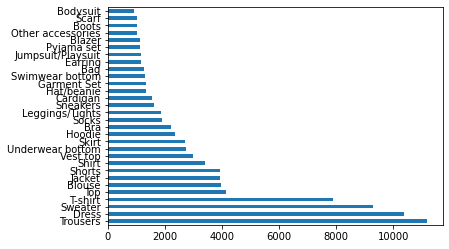

In [46]:
articles_df['product_type_name'].value_counts()[:30].plot(kind='barh')

In [47]:
print(articles_df['product_group_name'].unique())

['Garment Upper body' 'Underwear' 'Socks & Tights' 'Garment Lower body'
 'Accessories' 'Items' 'Nightwear' 'Unknown' 'Underwear/nightwear' 'Shoes'
 'Swimwear' 'Garment Full body' 'Cosmetic' 'Interior textile' 'Bags'
 'Furniture' 'Garment and Shoe care' 'Fun' 'Stationery']


<AxesSubplot:>

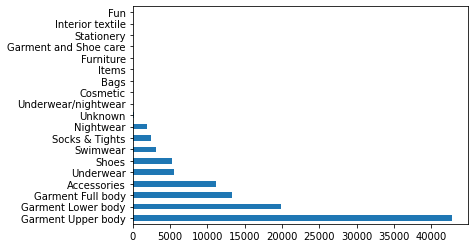

In [48]:
articles_df['product_group_name'].value_counts()[:50].plot(kind='barh')

In [49]:
print(articles_df['graphical_appearance_name'].unique())

['Solid' 'Stripe' 'All over pattern' 'Melange' 'Transparent' 'Metallic'
 'Application/3D' 'Denim' 'Colour blocking' 'Dot' 'Other structure'
 'Contrast' 'Treatment' 'Check' 'Chambray' 'Front print'
 'Glittering/Metallic' 'Mixed solid/pattern' 'Placement print'
 'Other pattern' 'Neps' 'Embroidery' 'Lace' 'Jacquard' 'Unknown' 'Argyle'
 'Slub' 'Mesh' 'Sequin' 'Hologram']


<AxesSubplot:>

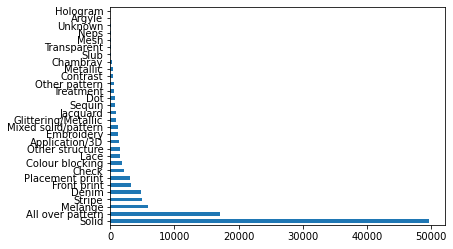

In [50]:
articles_df['graphical_appearance_name'].value_counts()[:35].plot(kind='barh')

In [51]:
print(articles_df['colour_group_name'].unique())

['Black' 'White' 'Off White' 'Light Beige' 'Beige' 'Grey' 'Light Blue'
 'Light Grey' 'Dark Blue' 'Dark Grey' 'Pink' 'Dark Red' 'Greyish Beige'
 'Light Orange' 'Silver' 'Gold' 'Light Pink' 'Dark Pink' 'Yellowish Brown'
 'Blue' 'Light Turquoise' 'Yellow' 'Greenish Khaki' 'Dark Yellow'
 'Other Pink' 'Dark Purple' 'Red' 'Transparent' 'Dark Green' 'Other Red'
 'Turquoise' 'Dark Orange' 'Other' 'Orange' 'Dark Beige' 'Other Yellow'
 'Light Green' 'Other Orange' 'Purple' 'Light Red' 'Light Yellow' 'Green'
 'Light Purple' 'Dark Turquoise' 'Other Purple' 'Bronze/Copper'
 'Other Turquoise' 'Other Green' 'Other Blue' 'Unknown']


<AxesSubplot:>

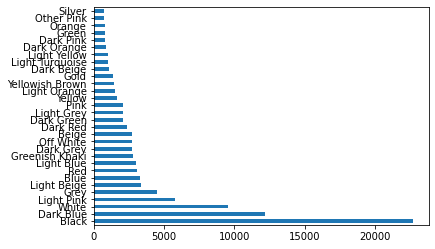

In [52]:
articles_df['colour_group_name'].value_counts()[:30].plot(kind='barh')

In [53]:
print(articles_df['perceived_colour_value_name'].unique())

['Dark' 'Light' 'Dusty Light' 'Medium Dusty' 'Bright' 'Medium' 'Undefined'
 'Unknown']


<AxesSubplot:>

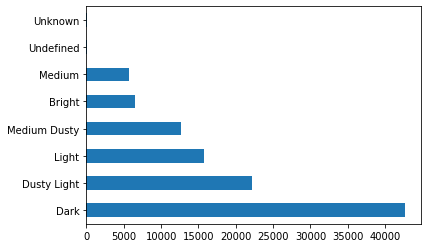

In [54]:
articles_df['perceived_colour_value_name'].value_counts()[:50].plot(kind='barh')

In [55]:
print(articles_df['perceived_colour_master_name'].unique())

['Black' 'White' 'Beige' 'Grey' 'Blue' 'Pink' 'Lilac Purple' 'Red' 'Mole'
 'Orange' 'Metal' 'Brown' 'Turquoise' 'Yellow' 'Khaki green' 'Green'
 'undefined' 'Unknown' 'Yellowish Green' 'Bluish Green']


<AxesSubplot:>

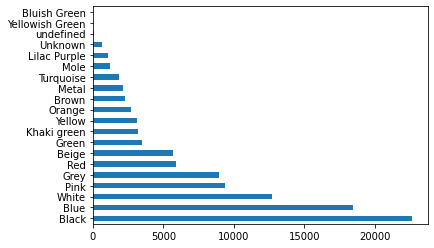

In [56]:
articles_df['perceived_colour_master_name'].value_counts()[:50].plot(kind='barh')

In [57]:
print(articles_df['department_name'].unique())

['Jersey Basic' 'Clean Lingerie' 'Tights basic' 'Baby basics'
 'Casual Lingerie' 'Jersey' 'EQ & Special Collections' 'Hair Accessories'
 'Other items' 'Baby Nightwear' 'Men Sport Woven' 'Men Sport Bottoms'
 'Kids Boy Denim' 'Shopbasket Socks' 'Socks' 'UW'
 'Young Girl Jersey Basic' 'Jacket Street' 'Belts' 'Divided Shoes'
 'Swimwear' 'Underwear Jersey' 'Basic 1' 'Tops Knitwear DS'
 'Men Sport Acc' 'Kids Boy Jersey Basic' 'Young Girl UW/NW' 'Shirt'
 'Nightwear' 'Trouser' 'Small Accessories' 'Sunglasses' 'Gloves/Hats'
 'Knit & Woven' 'Basics' 'Accessories' 'Jewellery' 'Jersey Fancy DS'
 'Trousers DS' 'Bags' 'Blazer S&T' 'Knitwear' 'Woven bottoms' 'Shorts'
 'Dresses DS' 'Expressive Lingerie' 'Kids Girl UW/NW'
 'Young Boy Jersey Basic' 'Kids Girl S&T' 'Young Girl S&T'
 'Shoes / Boots inactive from s5' 'Nursing' 'Jersey Fancy' 'Shoes'
 'Functional Lingerie' 'Men Sport Tops' 'Other Accessories'
 'Young Boy Trouser' 'Outdoor/Blazers DS' 'Mama Lingerie' 'Socks Bin'
 'Denim Other Garments' 'Ever

<AxesSubplot:>

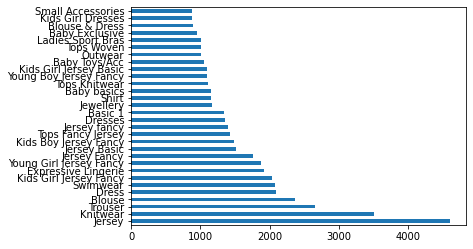

In [58]:
articles_df['department_name'].value_counts()[:30].plot(kind='barh')

In [59]:
print(articles_df['index_name'].unique())

['Ladieswear' 'Lingeries/Tights' 'Baby Sizes 50-98' 'Menswear'
 'Ladies Accessories' 'Sport' 'Children Sizes 92-140' 'Divided'
 'Children Sizes 134-170' 'Children Accessories, Swimwear']


<AxesSubplot:>

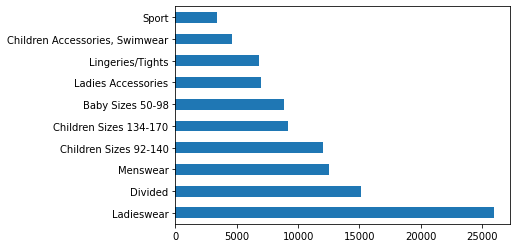

In [60]:
articles_df['index_name'].value_counts()[:50].plot(kind='barh')

In [61]:
print(articles_df['index_group_name'].unique())

['Ladieswear' 'Baby/Children' 'Menswear' 'Sport' 'Divided']


<AxesSubplot:>

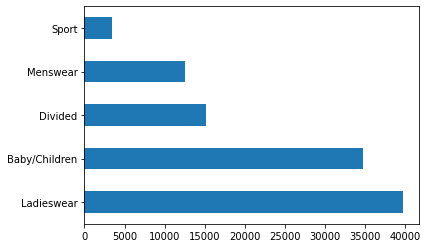

In [62]:
articles_df['index_group_name'].value_counts()[:50].plot(kind='barh')

In [63]:
print(articles_df['section_name'].unique())

['Womens Everyday Basics' 'Womens Lingerie'
 'Womens Nightwear, Socks & Tigh' 'Baby Essentials & Complements'
 'Men Underwear' 'Mama' 'Womens Small accessories' 'Men H&M Sport'
 'Kids Boy' 'Divided Basics' 'Girls Underwear & Basics' 'Mens Outerwear'
 'Womens Big accessories' 'Divided Accessories'
 'Womens Swimwear, beachwear' 'Divided Selected' 'Boys Underwear & Basics'
 'Contemporary Street' 'Contemporary Casual' 'Men Accessories'
 'Men Suits & Tailoring' 'Womens Everyday Collection' 'Men Shoes'
 'Young Boy' 'H&M+' 'Divided Collection' 'Ladies Denim'
 'Contemporary Smart' 'Womens Trend' 'Kids Outerwear' 'Young Girl'
 'Womens Shoes' 'Womens Tailoring' 'Divided Projects' 'Denim Men'
 'Men Other' 'Womens Jackets' 'Men Other 2' 'Baby Boy' 'Womens Casual'
 'Kids Accessories, Swimwear & D' 'Ladies H&M Sport' 'Kids & Baby Shoes'
 'Baby Girl' 'Kids Girl' 'Divided Complements Other' 'Womens Premium'
 'Special Collections' 'Kids Sports' 'Men Project' 'Men Edition'
 'Collaborations' 'Divided Asi

<AxesSubplot:>

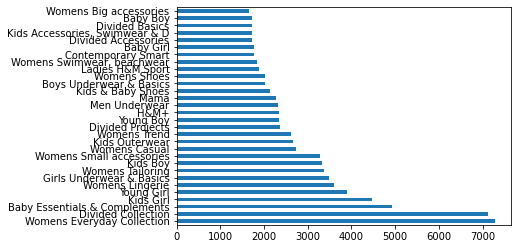

In [64]:
articles_df['section_name'].value_counts()[:30].plot(kind='barh')

In [65]:
print(articles_df['garment_group_name'].unique())

['Jersey Basic' 'Under-, Nightwear' 'Socks and Tights' 'Jersey Fancy'
 'Accessories' 'Trousers Denim' 'Outdoor' 'Shoes' 'Swimwear' 'Knitwear'
 'Shirts' 'Trousers' 'Dressed' 'Shorts' 'Dresses Ladies' 'Skirts'
 'Special Offers' 'Blouses' 'Unknown' 'Woven/Jersey/Knitted mix Baby'
 'Dresses/Skirts girls']


<AxesSubplot:>

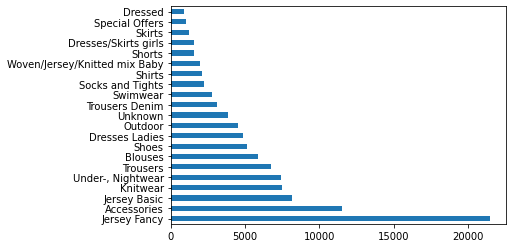

In [66]:
articles_df['garment_group_name'].value_counts()[:50].plot(kind='barh')

### ii. Customers <a class="anchor" id="customers2-bullet"></a>

[TOP ↑](#top)

The **customers_df** dataframe contains 7 features. 

| Variable | Data Type | Description |
| :--- | :--- | :--- |
| customer_id  | string | A unique ID for each customer. |
| FN | numeric | A boolean indicating if a customer gets the Fashion News newletter (1.0 or NaN).|
| Active | numeric | A boolean indicating if the customer is active for communication (1.0 or NaN). |
| club_member_status | string | Status of club membership: ACTIVE, PRE-CREATE, LEFT CLUB, or NaN. |
| fashion_news_frequency | string | Frequency of FN communication to the customer: Monthly, Regularly, NONE, None, or N/A. |
| age | numeric | The customer's age. |
| postal_code | string | The customer's postal code. |

There is some obvious correlation between the **FN** and **Active**. There is no customer who is listed as receieving the Fashion News newsletter but is also listed as inactive. We will therefore drop one of these features later on.

If we print the classes contained in the **club_member_status** feature, we can see that there are four, including the missing values.

In [67]:
print(customers_df['club_member_status'].unique())

['ACTIVE' nan 'PRE-CREATE' 'LEFT CLUB']


We can also visualise the distribution of classes in the  **club_member_status** feature.

<AxesSubplot:>

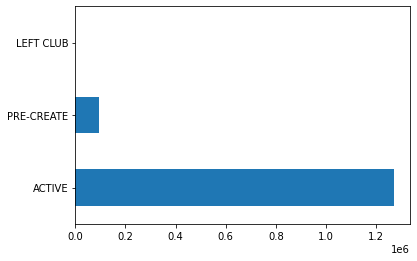

In [68]:
customers_df['club_member_status'].value_counts()[:100].plot(kind='barh')

We can also print the classes contained in the **fashion_news_frequency** feature. We can see that there are five, including the missing values, of which there are really three different types.

In [69]:
print(customers_df['fashion_news_frequency'].unique())

['NONE' 'Regularly' nan 'Monthly' 'None']


We can also generate a bar graph of the numbers.

<AxesSubplot:>

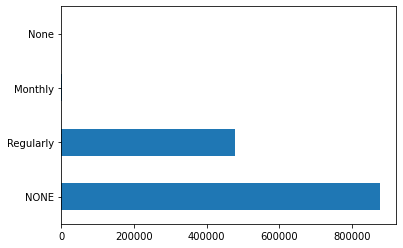

In [70]:
customers_df['fashion_news_frequency'].value_counts()[:100].plot(kind='barh')

Finally, we can produce a histogram to get an idea for the age distribution. We can see that it is broadly "bi-modal," with large numbers of "young" people between about 18 and 35 and "old" people between about 40 and 60. This will inform our feature engineering at a later stage.

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

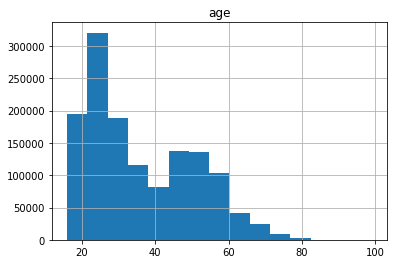

In [71]:
customers_df.hist(column='age', by=None, bins=15)

### iii. Transactions <a class="anchor" id="transactions2-bullet"></a>

[TOP ↑](#top)

The **transactions_df** dataframe contains 5 features. 

| Variable | Data Type | Description |
| :--- | :--- | :--- |
| t_dat  | date | The date of the transaction in YYYY-MM-DD format but provided as a string. |
| customer_id | string | The individual customer ID, identical to *customer_id* column in **customers_df**. |
| article_id | string | The individual article ID, identical to *article_id* in **articles_df**. |
| price | numeric | The normalised price paid for the item. |
| sales_channel_id | numeric | The sales channel: 1 is in-store, 2 is online. |

I'd like to remind myself how many customers are included in the transactions data.

In [72]:
transactions_df["customer_id"].nunique()

1362281

There are 1,362,281 customers included. This is the vast majority of the 1,371,980 customers in the **customers_df** table, but not all of them.

Next, I'd like to plot the number of transactions over time. We can see that there are a number of spikes.

<AxesSubplot:>

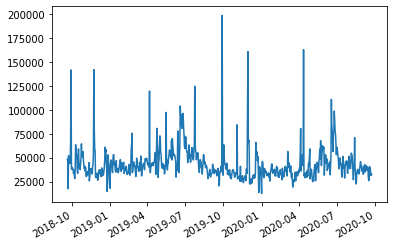

In [73]:
from matplotlib import pyplot
transactions_df['t_dat'].value_counts().plot()

Lastly, I'd like to see which sales channel is most popular. It seems online sales are more than double those in-store.

<AxesSubplot:>

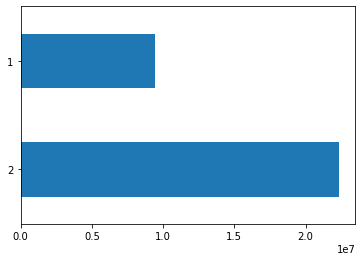

In [74]:
transactions_df['sales_channel_id'].value_counts()[:60].plot(kind='barh')

**Optimisation**

Lastly, duplicate rows correspond to customers who bought the same item multiple times in the same day, but since duplicate rows provide no extra information and just add to the burden on memory, I'll drop these duplicate rows from the transations data.  

In [75]:
#len(transactions_df)

In [76]:
#transactions_df = transactions_df.drop_duplicates()

In [77]:
#len(transactions_df)

 ## 3. Missing or Unusual Values <a class="anchor" id="third-bullet"></a>

[TOP ↑](#top)

The only file which contains missing or unusual values is the **customers_df** dataframe.

### Customers <a class="anchor" id="customers3-bullet"></a>

[TOP ↑](#top)

We will deal with each feature in turn.

#### i. club_member_status <a class="anchor" id="cms-bullet"></a>

[TOP ↑](#top)

This feature contains missing values.

In [78]:
print(customers_df['club_member_status'].unique())

['ACTIVE' nan 'PRE-CREATE' 'LEFT CLUB']


However, in this case, a missing value very likely indicates that a customer is inactive. In addition, whether or not a customer has not yet joined or has left the club is immaterial. They are simply inactive. I will therefore convert all classes which are not "ACTIVE" to "INACTIVE."

In [79]:
customers_df["club_member_status"] = customers_df["club_member_status"].fillna('INACTIVE')
customers_df["club_member_status"] = customers_df["club_member_status"].replace(["PRE-CREATE"], "INACTIVE")
customers_df["club_member_status"] = customers_df["club_member_status"].replace(["LEFT CLUB"], "INACTIVE")

In [80]:
print(customers_df['club_member_status'].unique())

['ACTIVE' 'INACTIVE']


#### ii. fashion_news_frequency <a class="anchor" id="fnf-bullet"></a>

[TOP ↑](#top)

This feature also contains missing values.

In [81]:
print(customers_df['fashion_news_frequency'].unique())

['NONE' 'Regularly' nan 'Monthly' 'None']


In this case, the missing values carry the same meaning as "NONE" and "None". We will therefore convert all of these to "NONE". 

In [82]:
customers_df["fashion_news_frequency"] = customers_df["fashion_news_frequency"].fillna('NONE')
customers_df["fashion_news_frequency"] = customers_df["fashion_news_frequency"].replace(["None"], "NONE")
customers_df["fashion_news_frequency"] = customers_df["fashion_news_frequency"].replace(["Regularly"], "REGULARLY")
#customers_df["fashion_news_frequency"] = customers_df["fashion_news_frequency"].replace(["Monthly"], "REGULARLY")

In [83]:
print(customers_df['fashion_news_frequency'].unique())

['NONE' 'REGULARLY' 'Monthly']


#### iii. FN <a class="anchor" id="fn-bullet"></a>

[TOP ↑](#top)

This feature contains a number of missing values. Once again, customers with missing values are more than likely not receiving the newsletter. We can therefore fill these missing values with "0". We can also take this opportunity to change the data type from float to integer.

In [84]:
customers_df["FN"] = customers_df["FN"].fillna(0)

In [85]:
customers_df["FN"] = customers_df["FN"].astype(int)

#### iv. Active <a class="anchor" id="active-bullet"></a>

[TOP ↑](#top)

This feature also contains a number of missing values. Once again, customers with missing values are more than likely not active. We can therefore also fill these missing values with "0". We can also take this opportunity to change the data type from float to integer.

In [86]:
customers_df["Active"] = customers_df["Active"].fillna(0)

In [87]:
customers_df["Active"] = customers_df["Active"].astype(int)

#### v. Age<a class="anchor" id="age-bullet"></a>

[TOP ↑](#top)

The age feature also contains a number of missing values. In this case, the best way to proceed will be to fill these missing values with the media age of all customers. This will be a neutral value.

In [88]:
customers_df["age"] = customers_df["age"].fillna(customers_df["age"].median())

Finally, we can check to see if these changes have been made correctly.

In [89]:
customers_df.isnull().sum()

customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
postal_code               0
dtype: int64

In [90]:
customers_df.nunique()

customer_id               1371980
FN                              2
Active                          2
club_member_status              2
fashion_news_frequency          3
age                            84
postal_code                352899
dtype: int64

In [91]:
print(customers_df['club_member_status'].unique())

['ACTIVE' 'INACTIVE']


In [92]:
print(customers_df['fashion_news_frequency'].unique())

['NONE' 'REGULARLY' 'Monthly']


## 4. Initial Feature Selection <a class="anchor" id="fourth-bullet"></a>

[TOP ↑](#top)

We can improve efficiency by ridding ourselves of unwanted features as early as possible.

### i. Articles <a class="anchor" id="articles-bullet"></a>

[TOP ↑](#top)

The articles_df contains a number of duplicated features, one numeric and one categorical. Having explored these in detail, we can now drop the categorical features as the numerical ones have slightly higher cardinality. The only exception is product_group_name as it has no numerical equivalent.

In [93]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [94]:
articles_df = articles_df[["article_id", "product_code", "product_type_no", "product_group_name", "graphical_appearance_no", "colour_group_code", "perceived_colour_value_id", "perceived_colour_master_id", "department_no", "index_code", "index_group_no", "section_no", "garment_group_no"]]
articles_df.head()

,article_id,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,108775015,108775,253,Garment Upper body,1010016,9,4,5,1676,A,1,16,1002
1,108775044,108775,253,Garment Upper body,1010016,10,3,9,1676,A,1,16,1002
2,108775051,108775,253,Garment Upper body,1010017,11,1,9,1676,A,1,16,1002
3,110065001,110065,306,Underwear,1010016,9,4,5,1339,B,1,61,1017
4,110065002,110065,306,Underwear,1010016,10,3,9,1339,B,1,61,1017


### ii. Customers <a class="anchor" id="articles-bullet"></a>

[TOP ↑](#top)

The articles_df contains a number of duplicated features, one numeric and one categorical. Having explored these in detail, we can now drop the categorical features as the numerical ones have slightly higher cardinality. The only exception is product_group_name as it has no numerical equivalent.

In [95]:
customers_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,0,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,1,ACTIVE,REGULARLY,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [96]:
customers_df = customers_df[["customer_id", "FN", "club_member_status", "fashion_news_frequency", "age"]]
customers_df.head()

,customer_id,FN,club_member_status,fashion_news_frequency,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,ACTIVE,NONE,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0,ACTIVE,NONE,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,ACTIVE,NONE,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,ACTIVE,NONE,54.0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1,ACTIVE,REGULARLY,52.0


 ## 5. Splitting the Data and Label Creation <a class="anchor" id="fifth-bullet"></a>

[TOP ↑](#top)

The strategy is to split the transactions data into transactions which took place prior to September 2020, called **transactions_prior**, and transactions which took place during September 2020, called **transactions_september**. We can use the articles purchased in September as our target labels for the training data. We can then develop a model to predict the purchases made in September 2020 based upon purchases made prior to September 2020. The thinking is that these predictions will not change much in the intervening time between model training and deployment.

The last day in the transaction dataframe is 2020-09-22. The public LB contains 1 week of transactions after this date. Therefore to create a local validation that mimics Kaggle's train test relationship, we can train on all transactions before 2020-9-15. And validate on the last week in train data.

First, we create our two dataframes.

In [97]:
cut_off_date = "2020-08-31"

In [98]:
transactions_prior = transactions_df.loc[transactions_df.t_dat <= pd.to_datetime(cut_off_date)]

In [99]:
transactions_prior["customer_id"].nunique()

1344743

In [100]:
transactions_september = transactions_df.loc[transactions_df.t_dat > pd.to_datetime(cut_off_date)]

In [101]:
transactions_september["customer_id"].nunique()

189510

Next, we need to create the labels for the training data. These are the **article_id**s from September. We can do this by first extracting the **customer_id** and **article_id** for each transaction in **transactions_september**. 

In [102]:
transactions_september_simplified = transactions_september[["customer_id", "article_id"]]

Now, we group the same customers and same articles together and count the quantity purchased.

In [103]:
transactions_september_simplified["article_id_2"] = transactions_september_simplified["article_id"]
f = {'customer_id': 'first', 'article_id': 'first', 'article_id_2': 'count'}
transactions_september_simplified = transactions_september_simplified.groupby(['customer_id', 'article_id'], as_index=False).agg(f)
transactions_september_simplified_new = transactions_september_simplified.rename({'article_id_2': 'quantity'}, axis='columns')
transactions_september_simplified_new.head()

/var/folders/rr/sx54y9js51n93l7h47hq62zr0000gn/T/ipykernel_5126/2253555329.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_september_simplified["article_id_2"] = transactions_september_simplified["article_id"]


,customer_id,article_id,quantity
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601043,1
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,794321007,1
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,448509014,1
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,719530003,1
4,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,685814001,3


Finally, we can drop the **quantity** column as we won't need it going forward.

In [104]:
transactions_september_simplified_new = transactions_september_simplified_new.drop(['quantity'], axis=1)

We can take a look at the final product.

In [105]:
transactions_september_simplified_new.head()

,customer_id,article_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601043
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,794321007
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,448509014
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,719530003
4,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,685814001


We'll make use of this dataframe to assign labels to the training data. I'll rename the data set for this purpose.

In [106]:
labels = transactions_september_simplified_new

We can get a sense of the size of this dataframe.

In [107]:
len(labels)

705504

In [108]:
labels.nunique()

customer_id    189510
article_id      26252
dtype: int64

We can also count the number of unique articles sold in September, 26,252 items, a measure of the potential number of classes we could have for our model. This number will, of course, be much smaller once we account for the popularity of the articles. 

In [109]:
number_of_potential_classes = labels['article_id'].nunique()
print(number_of_potential_classes)

26252


## 6. Merging DataFrames  <a class="anchor" id="sixth-bullet"></a>

[TOP ↑](#top)

In this next stage, we need to merge the transactions dataframe with the articles dataframe in order to match up each **article_id** in the transactions data with its broader category codes. We also merge these dataframes with the customers dataframe to pull in information relating to each of the customers. 

In [110]:
merged_df = transactions_prior.merge(articles_df, on='article_id')
merged_df = merged_df.merge(customers_df, on='customer_id')
merged_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,club_member_status,fashion_news_frequency,age
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,283,Underwear,1010016,9,4,5,1338,B,1,61,1017,0,ACTIVE,NONE,24.0
1,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,283,Underwear,1010016,9,4,5,1338,B,1,61,1017,0,ACTIVE,NONE,24.0
2,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,541518,306,Underwear,1010016,51,1,4,1334,B,1,61,1017,0,ACTIVE,NONE,24.0
3,2019-03-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,578020002,0.013542,2,578020,258,Garment Upper body,1010017,71,3,2,1510,A,1,6,1010,0,ACTIVE,NONE,24.0
4,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,351484002,0.022017,2,351484,59,Swimwear,1010016,9,4,5,4242,B,1,60,1018,0,ACTIVE,NONE,24.0


In [111]:
len(merged_df)

30990055

In [112]:
merged_df.shape

(30990055, 21)

In [113]:
merged_df.customer_id.nunique()

1344743

 ## 7. Machine Learning  <a class="anchor" id="seventh-bullet"></a>

[TOP ↑](#top)

Originaly, I had conceived of two approaches to this machine learning project, one using high or low grain purchasing data and one using aggregate descriptive features. In the end, the high grain purchasing approach proved too costly. The lower grain approach depends on prior purchases at higher level category classes, with fewer unique values. As an example, a customer's purchasing history might be measured by **department_no**, for which there are 299 classes of object, rather than at the level of individual **article_id**, which has a colossal 105,542 classes. These **department_no** categories are better understood by reference to the equivalent **department_name**, and include higher-level terms such as 'Sunglasses', 'Shorts', 'Shoes', 'Dresses', and so on. The second approach depends on customer information and aggregate descriptive features such as favourite colour. In the end, I combined these approaches in the hope that the data provided to the model would have some predictive capability, however limited. In fact, **department_no** proved to be the best feature to include, based on measure of information gain.

 ### i. Low Grain Purchasing Data  <a class="anchor" id="lgpd-bullet"></a>

[TOP ↑](#top)

The goal is to create a customer-category matrix containing the number of purchases made in that category during the prior transaction period, where the category is any one of the broader classes to which the article belongs. These are the higher-level product groupings, above the level of **article_id**. The list of all possible categories is below:

In [114]:
list_of_categories = [
        "product_code", "product_type_no", "product_group_name", "graphical_appearance_no", 
        "colour_group_code", "perceived_colour_value_id", "perceived_colour_master_id", 
        "department_no", "index_code", "index_group_no", "section_no", "garment_group_no"]

The time to run this code will depend on the number of classes in each category.

| Variable | Number of Classes |
| :--- | :--- |
| article_id | 105,542 |
| product_code | 47,224 |
| product_type_no | 131 |
| product_group_name | 19 |
| graphical_appearance_no  | 30|
| colour_group_code  | 50|
| perceived_colour_value_id | 8 |
| perceived_colour_master_id | 20|
| department_no | 299 |
| index_code | 10 |
| index_group_no  | 5|
| section_no | 56 |
| garment_group_no | 56|

We can choose the category we'd like to pivot customer-category matrix over by assigning this category to the variable, **pivot_column**. We can also set the minimum number of purchases required to include any article as a class label in the final model. The reasoning is that it's far better to recommend a popular article than a niche article. We can choose, for example, *min_count* = 850, to select only the top 20 articles. Our model will then assign 12 of these top 20 articles to each customer depending on their similarity to the customers included in the training data.

In [115]:
pivot_column = "department_no"
min_count = 930

**Generate Customer-Category Matrix**

[TOP ↑](#top)

In order to generate a customer-category quantity matrix, we need only the **customer_id** and the **pivot column**.

In [116]:
matrix_df = merged_df[["customer_id", pivot_column]]
matrix_df.head()

,customer_id,department_no
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1338
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1338
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1334
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1510
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,4242


Next, we group all the customers according to this category and the quantity purchased.

In [117]:
matrix_df["duplicate"] = matrix_df[pivot_column]
f = {'customer_id': 'first', pivot_column: 'first', 'duplicate': 'count'}
matrix_df = matrix_df.groupby(['customer_id', pivot_column], as_index=False).agg(f)
matrix_df = matrix_df.rename({'duplicate': 'quantity'}, axis='columns')
matrix_df.head()

/var/folders/rr/sx54y9js51n93l7h47hq62zr0000gn/T/ipykernel_5126/2816286557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_df["duplicate"] = matrix_df[pivot_column]


,customer_id,department_no,quantity
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1212,4
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1244,1
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1322,1
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1515,1
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1616,1


Next, we pivot the dataframe so that the category codes become columns and the quantity purchased becomes the values.

In [118]:
pivot_df = matrix_df.pivot(index='customer_id', columns=pivot_column, values='quantity')

In [119]:
pivot_df.head()

department_no,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,1.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN,2.0,2.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,2.0,1.0,NaN,NaN,1.0,3.0,NaN,NaN,4.0,NaN,NaN,NaN,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,N

We can check the size of the new dataframe and investigate how many missing values are present.

In [120]:
len(pivot_df)

1344743

In [121]:
pivot_df.isnull().sum()

department_no
1201    1167010
1202    1343906
1212    1245066
1222    1239035
1241    1337238
         ...   
9020    1343016
9984    1322751
9985    1318943
9986    1325532
9989    1335244
Length: 299, dtype: int64

Next, we can print the head.

In [122]:
pivot_df.head()

department_no,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989
customer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,1.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN,2.0,2.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0,2.0,1.0,NaN,NaN,1.0,3.0,NaN,NaN,4.0,NaN,NaN,NaN,2.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,N

Now, we need to flatten the dataframe.

In [123]:
#pivot_df = pivot_df.rename_axis(None, axis=1)
pivot_df = pivot_df.rename_axis(None, axis=1).reset_index()

Next, we must fill the missing values with "0", indicating no purchases.

In [124]:
pivot_df = pivot_df.fillna(0)
pivot_df.head()

,customer_id,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

Next, we can convert the floats to integer values.

In [125]:
pivot_df.iloc[:, 1:len(pivot_df.columns)] = pivot_df.iloc[:, 1:len(pivot_df.columns)].astype(int)
pivot_df.head()

,customer_id,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1,0,0,2,0,0,1,0,2,2,0,1,0,0,2,0,0,0,2,1,0,0,0,2,0,0,0,0,0,1,0,2,2,1,0,0,1,3,0,0,4,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

 ### ii. Customer Information <a class="anchor" id="ci-bullet"></a>

[TOP ↑](#top)

Next, we can merge this customer-category matrix with the customer information taken from **customers_df**, inclusive of **FN**, **club_member_status**, **fashion_news_frequency**, and **age**.

In [126]:
df = pivot_df.merge(customers_df, on='customer_id')
df.head()

,customer_id,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,club_member_status,fashion_news_frequency,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,49.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1,0,0,2,0,0,1,0,2,2,0,1,0,0,2,0,0,0,2,1,0,0,0,2,0,0,0,0,0,1,0,2,2,1,0,0,1,3,0,0,4,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,25.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,24.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [127]:
len(df)

1344743

In [128]:
df.shape

(1344743, 304)

### iii. Aggregate Descriptive Features  <a class="anchor" id="adf-bullet"></a>

[TOP ↑](#top)

In addition to the prior purchasing data and the customer information, I'd like to include some aggregate descriptive features. A person is likely to choose their clothes based on colour, pattern, and brand. The brand information is unavailable, but we can extract a customer's favourite colours if we sort their purchases according to colour and take the top two. I have explored all sorts of options, such as favourite colours, favourite pattern, and regularity of purchases. Through investigating the usefulness of these features, I have opted to include fave_colour, 2nd_fave_colour, and fave_pattern.

#### a. Favourite Colour  <a class="anchor" id="colour-bullet"></a>

[TOP ↑](#top)

First, we can engineer a feature which captures the customer's favourite colour. We extract the **colour_group_code** from the merged dataframe.

In [129]:
colour_df = merged_df[["customer_id", "colour_group_code"]]
colour_df.head()

,customer_id,colour_group_code
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,9
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,9
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,51
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,71
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,9


Next, we group all the customers according to colour_group_code and the count.

In [130]:
colour_df["colour_group_code_2"] = colour_df["colour_group_code"]
f = {'customer_id': 'first', 'colour_group_code': 'first', 'colour_group_code_2': 'count'}
colour_df = colour_df.groupby(['customer_id', 'colour_group_code'], as_index=False).agg(f)
colour_df = colour_df.rename({'colour_group_code_2': 'count'}, axis='columns')
colour_df.head()

/var/folders/rr/sx54y9js51n93l7h47hq62zr0000gn/T/ipykernel_5126/310321360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colour_df["colour_group_code_2"] = colour_df["colour_group_code"]


,customer_id,colour_group_code,count
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,9,14
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,11,1
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,12,1
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,19,1
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,51,1


In [131]:
#top_colours_df = df[df['count'] == df.groupby(['customer_id'])['count'].transform(max)]
#top_colours_df.head()

Next, we take those rows with the maximum count.

In [132]:
idx=colour_df.groupby(by='customer_id')['count'].idxmax()
colour_df_max=colour_df.loc[idx,]

In [133]:
colour_df_max.head()

,customer_id,colour_group_code,count
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,9,14
9,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,9,26
25,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,9,7
31,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,9,2
32,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,9,9


We can confirm the number of unique customers.

In [134]:
colour_df_max.customer_id.nunique()

1344743

Finally, we can drop the count column.

In [135]:
colour_df_max = colour_df_max.drop(['count'], axis=1)
colour_df_max.head()

,customer_id,colour_group_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,9
9,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,9
25,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,9
31,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,9
32,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,9


For ease of interpretation, we rename the colour code column.

In [136]:
colour_df_max = colour_df_max.rename(columns={"colour_group_code": "fave_colour"})
colour_df_max.head()

,customer_id,fave_colour
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,9
9,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,9
25,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,9
31,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,9
32,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,9


We can get a feel for the distribution of colours.

<AxesSubplot:>

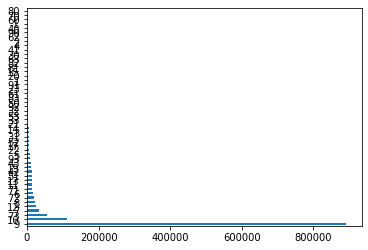

In [137]:
colour_df_max['fave_colour'].value_counts()[:50].plot(kind='barh')

#### b. Second Favourite Colour  <a class="anchor" id="2fc-bullet"></a>

[TOP ↑](#top)

Perhaps even more important than favourite colour is a customer's second favourite colour. We can repeat the same process as above, but extract the **colour_group_code** with second largest count.

In [138]:
colour_df.head()

,customer_id,colour_group_code,count
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,9,14
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,11,1
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,12,1
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,19,1
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,51,1


Next, we take the second highest count.

In [139]:
colour_df_2 = (colour_df.sort_values('count', ascending=False).groupby('customer_id', as_index=False).nth(1))

In [140]:
colour_df_2.head()

,customer_id,colour_group_code,count
5344453,8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d...,10,208
6267342,a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...,10,183
5924619,9d50687e366b49577c136952613632b9f157cb9051cb71...,19,182
3901302,67931690bdf18d2e328854ae772cd5ce2505fdc1116469...,10,160
6417755,aa5d58330818c507141333ef2f4874481921a07fde38f3...,10,156


There are fewer 2nd favourite colours, as some customers have bought just one item. We can fill these missing value later on.

In [141]:
colour_df_2.customer_id.nunique()

1135427

In [142]:
colour_df_2 = colour_df_2.drop(['count'], axis=1)
colour_df_2.head()

,customer_id,colour_group_code
5344453,8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d...,10
6267342,a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...,10
5924619,9d50687e366b49577c136952613632b9f157cb9051cb71...,19
3901302,67931690bdf18d2e328854ae772cd5ce2505fdc1116469...,10
6417755,aa5d58330818c507141333ef2f4874481921a07fde38f3...,10


In [143]:
colour_df_2 = colour_df_2.rename(columns={"colour_group_code": "2nd_fave_colour"})
colour_df_2.head()

,customer_id,2nd_fave_colour
5344453,8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d...,10
6267342,a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...,10
5924619,9d50687e366b49577c136952613632b9f157cb9051cb71...,19
3901302,67931690bdf18d2e328854ae772cd5ce2505fdc1116469...,10
6417755,aa5d58330818c507141333ef2f4874481921a07fde38f3...,10


<AxesSubplot:>

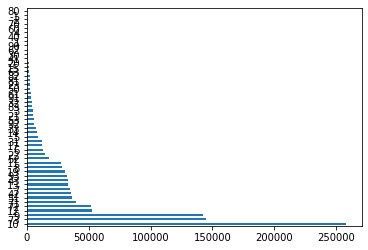

In [144]:
colour_df_2['2nd_fave_colour'].value_counts()[:50].plot(kind='barh')

#### c. Favourite Pattern  <a class="anchor" id="fp-bullet"></a>

[TOP ↑](#top)

In [145]:
pattern_df = merged_df[["customer_id", "graphical_appearance_no"]]
pattern_df.head()

,customer_id,graphical_appearance_no
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1010016
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1010016
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1010016
3,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1010017
4,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1010016


Next, we group all the customers with the products and quantity purchased.

In [146]:
pattern_df["graphical_appearance_no_2"] = pattern_df["graphical_appearance_no"]
f = {'customer_id': 'first', 'graphical_appearance_no': 'first', 'graphical_appearance_no_2': 'count'}
pattern_df = pattern_df.groupby(['customer_id', 'graphical_appearance_no'], as_index=False).agg(f)
pattern_df = pattern_df.rename({'graphical_appearance_no_2': 'count'}, axis='columns')
pattern_df.head()

/var/folders/rr/sx54y9js51n93l7h47hq62zr0000gn/T/ipykernel_5126/3359792797.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pattern_df["graphical_appearance_no_2"] = pattern_df["graphical_appearance_no"]


,customer_id,graphical_appearance_no,count
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1010001,3
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1010006,2
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1010016,13
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1010017,1
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1010023,1


In [147]:
idx=pattern_df.groupby(by='customer_id')['count'].idxmax()
pattern_df_max=pattern_df.loc[idx,]

In [148]:
pattern_df_max.head()

,customer_id,graphical_appearance_no,count
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1010016,13
9,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1010016,36
16,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1010016,10
19,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,1010016,2
22,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1010016,6


In [149]:
pattern_df_max = pattern_df_max.drop(['count'], axis=1)
pattern_df_max.head()

,customer_id,graphical_appearance_no
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1010016
9,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1010016
16,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1010016
19,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,1010016
22,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1010016


In [150]:
pattern_df = pattern_df_max.rename(columns={"graphical_appearance_no": "fave_pattern"})
pattern_df.head()

,customer_id,fave_pattern
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,1010016
9,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1010016
16,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,1010016
19,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,1010016
22,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1010016


<AxesSubplot:>

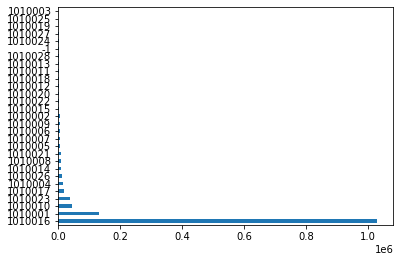

In [151]:
pattern_df['fave_pattern'].value_counts()[:50].plot(kind='barh')

In [152]:
len(colour_df)

9637161

In [153]:
len(pattern_df)

1344743

In [154]:
df.customer_id.nunique()

1344743

In [155]:
df = df.merge(colour_df_max, on='customer_id')
df.head()

,customer_id,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,club_member_status,fashion_news_frequency,age,fave_colour
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,49.0,9
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1,0,0,2,0,0,1,0,2,2,0,1,0,0,2,0,0,0,2,1,0,0,0,2,0,0,0,0,0,1,0,2,2,1,0,0,1,3,0,0,4,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,25.0,9
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,24.0,9
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [156]:
df.customer_id.nunique()

1344743

In [157]:
df = df.merge(colour_df_2, on='customer_id', how="left")
df.head()

,customer_id,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,club_member_status,fashion_news_frequency,age,fave_colour,2nd_fave_colour
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,49.0,9,73.0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1,0,0,2,0,0,1,0,2,2,0,1,0,0,2,0,0,0,2,1,0,0,0,2,0,0,0,0,0,1,0,2,2,1,0,0,1,3,0,0,4,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,25.0,9,73.0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,24.0,9,71.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [158]:
df.isnull().sum()

customer_id                    0
1201                           0
1202                           0
1212                           0
1222                           0
                           ...  
club_member_status             0
fashion_news_frequency         0
age                            0
fave_colour                    0
2nd_fave_colour           209316
Length: 306, dtype: int64

In [159]:
df = df.fillna("Unknown")

In [160]:
df.isnull().sum()

customer_id               0
1201                      0
1202                      0
1212                      0
1222                      0
                         ..
club_member_status        0
fashion_news_frequency    0
age                       0
fave_colour               0
2nd_fave_colour           0
Length: 306, dtype: int64

In [161]:
df = df.merge(pattern_df, on='customer_id', how="left")
df.head()

,customer_id,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,club_member_status,fashion_news_frequency,age,fave_colour,2nd_fave_colour,fave_pattern
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,49.0,9,73.0,1010016
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1,0,0,2,0,0,1,0,2,2,0,1,0,0,2,0,0,0,2,1,0,0,0,2,0,0,0,0,0,1,0,2,2,1,0,0,1,3,0,0,4,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,25.0,9,73.0,1010016
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,24.0,9,71.0,1010016
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [162]:
df.isnull().sum()

customer_id               0
1201                      0
1202                      0
1212                      0
1222                      0
                         ..
fashion_news_frequency    0
age                       0
fave_colour               0
2nd_fave_colour           0
fave_pattern              0
Length: 307, dtype: int64

In [163]:
df.customer_id.nunique()

1344743

In [164]:
#df = df.merge(pattern_df, on='customer_id')
df.head()

,customer_id,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,club_member_status,fashion_news_frequency,age,fave_colour,2nd_fave_colour,fave_pattern
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,49.0,9,73.0,1010016
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1,0,0,2,0,0,1,0,2,2,0,1,0,0,2,0,0,0,2,1,0,0,0,2,0,0,0,0,0,1,0,2,2,1,0,0,1,3,0,0,4,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,25.0,9,73.0,1010016
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,24.0,9,71.0,1010016
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### iv. Binning and Encoding <a class="anchor" id="bae-bullet"></a>

[TOP ↑](#top)

Next, we will perform some binning and encoding. The **age** feature is broadly bi-modal, so it might be worth binning the ages into two broad categories: young and old. The categorical values of many features also need to be encoded. We will use both one-hot-encoding and ordinal encoding.

#### a. Age Binning  <a class="anchor" id="age2-bullet"></a>

[TOP ↑](#top)

In [165]:
df["age_binned"] = pd.qcut(df["age"], 2, labels=["young", "old"])
df.head()

,customer_id,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,club_member_status,fashion_news_frequency,age,fave_colour,2nd_fave_colour,fave_pattern,age_binned
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,49.0,9,73.0,1010016,old
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,1,0,0,2,0,0,1,0,2,2,0,1,0,0,2,0,0,0,2,1,0,0,0,2,0,0,0,0,0,1,0,2,2,1,0,0,1,3,0,0,4,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,25.0,9,73.0,1010016,young
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,1,0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ACTIVE,NONE,24.0,9,71.0,1010016,young
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [166]:
df = df.drop(['age'], axis=1)

In [167]:
len(df)

1344743

In [168]:
df.shape

(1344743, 307)

#### b. One-Hot-Encoding  <a class="anchor" id="ohe-bullet"></a>

[TOP ↑](#top)

Next, we can one-hot-encode the **club_member_status** and **age_binned** features, as well as the customer's **fave_colour**, **2nd_fave_colour**, and **fave_pattern**.

In [169]:
df = pd.get_dummies(df, columns=["club_member_status", "age_binned"])
df.shape

(1344743, 309)

In [170]:
df = pd.get_dummies(df, columns=["fave_colour", "2nd_fave_colour", "fave_pattern"])
df.shape

(1344743, 436)

#### c. Ordinal Encoding <a class="anchor" id="oe-bullet"></a>

[TOP ↑](#top)

In the case of the **fashion_news_frequency** feature, its values actually have an inherent order. It is clear that the frequency increases as you move from NONE to Monthly to Regular, i.e. NONE < Monthly < Regularly. We will, therefore, encode these values as 0, 1, and 2.

In [171]:
df['fashion_news_frequency'] = df['fashion_news_frequency'].replace('NONE', 0)

In [172]:
df['fashion_news_frequency'] = df['fashion_news_frequency'].replace('Monthly', 1)

In [173]:
df['fashion_news_frequency'] = df['fashion_news_frequency'].replace('REGULARLY', 2)

In [174]:
df.head()

,customer_id,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,fashion_news_frequency,club_member_status_ACTIVE,club_member_status_INACTIVE,age_binned_young,age_binned_old,fave_colour_-1,fave_colour_1,fave_colour_2,fave_colour_3,fave_colour_4,fave_colour_5,fave_colour_6,fave_colour_7,fave_colour_8,fave_colour_9,fave_colour_10,fave_colour_11,fave_colour_12,fave_colour_13,fave_colour_14,fave_colour_15,fave_colour_17,fave_colour_19,fave_colour_20,fave_colour_21,fave_colour_22,fave_colour_23,fave_colour_30,fave_colour_31,fave_colour_32,fave_colour_33,fave_colour_40,fave_colour_41,fave_colour_42,fave_colour_43,fave_colour_50,fave_colour_51,fave_colour_52,fave_colour_53,fave_colour_60,fave_colour_61,fave_colour_62,fave_colour_63,fave_colour_70,fave_colour_71,fave_colour_72,fave_colour_73,fave_colour_80,fave_colour_81,fave_colour_82,fave_colour_83,fave_colour_90,fave_colour_91,fave_colour_92,fave_colour_93,2nd_fave_colour_-1.0,2nd_fave_colour_1.0,2nd_fave_colour_2.0,2nd_fave_colour_3.0,2nd_fave_colour_4.0,2nd_fave_colour_5.0,2nd_fave_colour_6.0,2nd_fave_colour_7.0,2nd_fave_colour_8.0,2nd_fave_colour_9.0,2nd_fave_colour_10.0,2nd_fave_colour_11.0,2nd_fave_colour_12.0,2nd_fave_colour_13.0,2nd_fave_colour_14.0,2nd_fave_colour_15.0,2nd_fave_colour_17.0,2nd_fave_colour_19.0,2nd_fave_colour_20.0,2nd_fave_colour_21.0,2nd_fave_colour_22.0,2nd_fave_colour_23.0,2nd_fave_colour_30.0,2nd_fave_colour_31.0,2nd_fave_colour_32.0,2nd_fave_colour_33.0,2nd_fave_colour_40.0,2nd_fave_colour_41.0,2nd_fave_colour_42.0,2nd_fave_colour_43.0,2nd_fave_colour_50.0,2nd_fave_colour_51.0,2nd_fave_colour_52.0,2nd_fave_colour_53.0,2nd_fave_colour_60.0,2nd_fave_colour_61.0,2nd_fave_colour_62.0,2nd_fave_colour_63.0,2nd_fave_colour_70.0,2nd_fave_colour_71.0,2nd_fave_colour_72.0,2nd_fave_colour_73.0,2nd_fave_colour_80.0,2nd_fave_colour_81.0,2nd_fave_colour_82.0,2nd_fave_colour_83.0,2nd_fave_colour_90.0,2nd_fave_colour_91.0,2nd_fave_colour_92.0,2nd_fave_colour_93.0,2nd_fave_colour_Unknown,fave_pattern_-1,fave_pattern_1010001,fave_pattern_1010002,fave_pattern_1010003,fave_pattern_1010004,fave_pattern_1010005,fave_pattern_1010006,fave_pattern_1010007,fave_pattern_1010008,fave_pattern_1010009,fave_pattern_1010010,fave_pattern_1010011,fave_pattern_1010012,fave_pattern_1010013,fave_pattern_1010014,fave_pattern_1010015,fave_pattern_1010016,fave_pattern_1010017,fave_pattern_1010018,fave_pattern_1010019,fave_pattern_1010020,fave_pattern_1010021,fave_pattern_1010022,fave_pattern_1010023,fave_pattern_1010024,fave_pattern_1010025,fave_pattern_1010026,fave_pattern

### v. Analytical Base Table <a class="anchor" id="abt-bullet"></a>

[TOP ↑](#top)

Next, we need to build our analytical base table, containing all the data plus the labels, from which we can sample the training and test data.

In [175]:
abt_df = df

In [176]:
abt_df.head()

,customer_id,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,fashion_news_frequency,club_member_status_ACTIVE,club_member_status_INACTIVE,age_binned_young,age_binned_old,fave_colour_-1,fave_colour_1,fave_colour_2,fave_colour_3,fave_colour_4,fave_colour_5,fave_colour_6,fave_colour_7,fave_colour_8,fave_colour_9,fave_colour_10,fave_colour_11,fave_colour_12,fave_colour_13,fave_colour_14,fave_colour_15,fave_colour_17,fave_colour_19,fave_colour_20,fave_colour_21,fave_colour_22,fave_colour_23,fave_colour_30,fave_colour_31,fave_colour_32,fave_colour_33,fave_colour_40,fave_colour_41,fave_colour_42,fave_colour_43,fave_colour_50,fave_colour_51,fave_colour_52,fave_colour_53,fave_colour_60,fave_colour_61,fave_colour_62,fave_colour_63,fave_colour_70,fave_colour_71,fave_colour_72,fave_colour_73,fave_colour_80,fave_colour_81,fave_colour_82,fave_colour_83,fave_colour_90,fave_colour_91,fave_colour_92,fave_colour_93,2nd_fave_colour_-1.0,2nd_fave_colour_1.0,2nd_fave_colour_2.0,2nd_fave_colour_3.0,2nd_fave_colour_4.0,2nd_fave_colour_5.0,2nd_fave_colour_6.0,2nd_fave_colour_7.0,2nd_fave_colour_8.0,2nd_fave_colour_9.0,2nd_fave_colour_10.0,2nd_fave_colour_11.0,2nd_fave_colour_12.0,2nd_fave_colour_13.0,2nd_fave_colour_14.0,2nd_fave_colour_15.0,2nd_fave_colour_17.0,2nd_fave_colour_19.0,2nd_fave_colour_20.0,2nd_fave_colour_21.0,2nd_fave_colour_22.0,2nd_fave_colour_23.0,2nd_fave_colour_30.0,2nd_fave_colour_31.0,2nd_fave_colour_32.0,2nd_fave_colour_33.0,2nd_fave_colour_40.0,2nd_fave_colour_41.0,2nd_fave_colour_42.0,2nd_fave_colour_43.0,2nd_fave_colour_50.0,2nd_fave_colour_51.0,2nd_fave_colour_52.0,2nd_fave_colour_53.0,2nd_fave_colour_60.0,2nd_fave_colour_61.0,2nd_fave_colour_62.0,2nd_fave_colour_63.0,2nd_fave_colour_70.0,2nd_fave_colour_71.0,2nd_fave_colour_72.0,2nd_fave_colour_73.0,2nd_fave_colour_80.0,2nd_fave_colour_81.0,2nd_fave_colour_82.0,2nd_fave_colour_83.0,2nd_fave_colour_90.0,2nd_fave_colour_91.0,2nd_fave_colour_92.0,2nd_fave_colour_93.0,2nd_fave_colour_Unknown,fave_pattern_-1,fave_pattern_1010001,fave_pattern_1010002,fave_pattern_1010003,fave_pattern_1010004,fave_pattern_1010005,fave_pattern_1010006,fave_pattern_1010007,fave_pattern_1010008,fave_pattern_1010009,fave_pattern_1010010,fave_pattern_1010011,fave_pattern_1010012,fave_pattern_1010013,fave_pattern_1010014,fave_pattern_1010015,fave_pattern_1010016,fave_pattern_1010017,fave_pattern_1010018,fave_pattern_1010019,fave_pattern_1010020,fave_pattern_1010021,fave_pattern_1010022,fave_pattern_1010023,fave_pattern_1010024,fave_pattern_1010025,fave_pattern_1010026,fave_pattern

In [177]:
len(abt_df)

1344743

In [178]:
abt_df.shape

(1344743, 436)

In [179]:
abt_df.customer_id.nunique()

1344743

In [180]:
#abt_df = abt_df.merge(customers_df, on='customer_id')
#abt_df.head()

We need to save a copy of this dataframe in order to make predictions during deployment.

In [181]:
all_customers_in_prior_transactions_df = abt_df.copy()

#### a. Labelling the Data <a class="anchor" id="ltd-bullet"></a>

Next, we can add the labels to the baset table.

In [182]:
df = abt_df.merge(labels, on='customer_id')
df.head()

,customer_id,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,fashion_news_frequency,club_member_status_ACTIVE,club_member_status_INACTIVE,age_binned_young,age_binned_old,fave_colour_-1,fave_colour_1,fave_colour_2,fave_colour_3,fave_colour_4,fave_colour_5,fave_colour_6,fave_colour_7,fave_colour_8,fave_colour_9,fave_colour_10,fave_colour_11,fave_colour_12,fave_colour_13,fave_colour_14,fave_colour_15,fave_colour_17,fave_colour_19,fave_colour_20,fave_colour_21,fave_colour_22,fave_colour_23,fave_colour_30,fave_colour_31,fave_colour_32,fave_colour_33,fave_colour_40,fave_colour_41,fave_colour_42,fave_colour_43,fave_colour_50,fave_colour_51,fave_colour_52,fave_colour_53,fave_colour_60,fave_colour_61,fave_colour_62,fave_colour_63,fave_colour_70,fave_colour_71,fave_colour_72,fave_colour_73,fave_colour_80,fave_colour_81,fave_colour_82,fave_colour_83,fave_colour_90,fave_colour_91,fave_colour_92,fave_colour_93,2nd_fave_colour_-1.0,2nd_fave_colour_1.0,2nd_fave_colour_2.0,2nd_fave_colour_3.0,2nd_fave_colour_4.0,2nd_fave_colour_5.0,2nd_fave_colour_6.0,2nd_fave_colour_7.0,2nd_fave_colour_8.0,2nd_fave_colour_9.0,2nd_fave_colour_10.0,2nd_fave_colour_11.0,2nd_fave_colour_12.0,2nd_fave_colour_13.0,2nd_fave_colour_14.0,2nd_fave_colour_15.0,2nd_fave_colour_17.0,2nd_fave_colour_19.0,2nd_fave_colour_20.0,2nd_fave_colour_21.0,2nd_fave_colour_22.0,2nd_fave_colour_23.0,2nd_fave_colour_30.0,2nd_fave_colour_31.0,2nd_fave_colour_32.0,2nd_fave_colour_33.0,2nd_fave_colour_40.0,2nd_fave_colour_41.0,2nd_fave_colour_42.0,2nd_fave_colour_43.0,2nd_fave_colour_50.0,2nd_fave_colour_51.0,2nd_fave_colour_52.0,2nd_fave_colour_53.0,2nd_fave_colour_60.0,2nd_fave_colour_61.0,2nd_fave_colour_62.0,2nd_fave_colour_63.0,2nd_fave_colour_70.0,2nd_fave_colour_71.0,2nd_fave_colour_72.0,2nd_fave_colour_73.0,2nd_fave_colour_80.0,2nd_fave_colour_81.0,2nd_fave_colour_82.0,2nd_fave_colour_83.0,2nd_fave_colour_90.0,2nd_fave_colour_91.0,2nd_fave_colour_92.0,2nd_fave_colour_93.0,2nd_fave_colour_Unknown,fave_pattern_-1,fave_pattern_1010001,fave_pattern_1010002,fave_pattern_1010003,fave_pattern_1010004,fave_pattern_1010005,fave_pattern_1010006,fave_pattern_1010007,fave_pattern_1010008,fave_pattern_1010009,fave_pattern_1010010,fave_pattern_1010011,fave_pattern_1010012,fave_pattern_1010013,fave_pattern_1010014,fave_pattern_1010015,fave_pattern_1010016,fave_pattern_1010017,fave_pattern_1010018,fave_pattern_1010019,fave_pattern_1010020,fave_pattern_1010021,fave_pattern_1010022,fave_pattern_1010023,fave_pattern_1010024,fave_pattern_1010025,fave_pattern_1010026,fave_pattern

In [183]:
len(df)

651172

In [184]:
df.customer_id.nunique()

171972

Finally, we can drop the **customer_id** column.

In [185]:
df = df.drop(['customer_id'], axis=1)
df.head()

,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,fashion_news_frequency,club_member_status_ACTIVE,club_member_status_INACTIVE,age_binned_young,age_binned_old,fave_colour_-1,fave_colour_1,fave_colour_2,fave_colour_3,fave_colour_4,fave_colour_5,fave_colour_6,fave_colour_7,fave_colour_8,fave_colour_9,fave_colour_10,fave_colour_11,fave_colour_12,fave_colour_13,fave_colour_14,fave_colour_15,fave_colour_17,fave_colour_19,fave_colour_20,fave_colour_21,fave_colour_22,fave_colour_23,fave_colour_30,fave_colour_31,fave_colour_32,fave_colour_33,fave_colour_40,fave_colour_41,fave_colour_42,fave_colour_43,fave_colour_50,fave_colour_51,fave_colour_52,fave_colour_53,fave_colour_60,fave_colour_61,fave_colour_62,fave_colour_63,fave_colour_70,fave_colour_71,fave_colour_72,fave_colour_73,fave_colour_80,fave_colour_81,fave_colour_82,fave_colour_83,fave_colour_90,fave_colour_91,fave_colour_92,fave_colour_93,2nd_fave_colour_-1.0,2nd_fave_colour_1.0,2nd_fave_colour_2.0,2nd_fave_colour_3.0,2nd_fave_colour_4.0,2nd_fave_colour_5.0,2nd_fave_colour_6.0,2nd_fave_colour_7.0,2nd_fave_colour_8.0,2nd_fave_colour_9.0,2nd_fave_colour_10.0,2nd_fave_colour_11.0,2nd_fave_colour_12.0,2nd_fave_colour_13.0,2nd_fave_colour_14.0,2nd_fave_colour_15.0,2nd_fave_colour_17.0,2nd_fave_colour_19.0,2nd_fave_colour_20.0,2nd_fave_colour_21.0,2nd_fave_colour_22.0,2nd_fave_colour_23.0,2nd_fave_colour_30.0,2nd_fave_colour_31.0,2nd_fave_colour_32.0,2nd_fave_colour_33.0,2nd_fave_colour_40.0,2nd_fave_colour_41.0,2nd_fave_colour_42.0,2nd_fave_colour_43.0,2nd_fave_colour_50.0,2nd_fave_colour_51.0,2nd_fave_colour_52.0,2nd_fave_colour_53.0,2nd_fave_colour_60.0,2nd_fave_colour_61.0,2nd_fave_colour_62.0,2nd_fave_colour_63.0,2nd_fave_colour_70.0,2nd_fave_colour_71.0,2nd_fave_colour_72.0,2nd_fave_colour_73.0,2nd_fave_colour_80.0,2nd_fave_colour_81.0,2nd_fave_colour_82.0,2nd_fave_colour_83.0,2nd_fave_colour_90.0,2nd_fave_colour_91.0,2nd_fave_colour_92.0,2nd_fave_colour_93.0,2nd_fave_colour_Unknown,fave_pattern_-1,fave_pattern_1010001,fave_pattern_1010002,fave_pattern_1010003,fave_pattern_1010004,fave_pattern_1010005,fave_pattern_1010006,fave_pattern_1010007,fave_pattern_1010008,fave_pattern_1010009,fave_pattern_1010010,fave_pattern_1010011,fave_pattern_1010012,fave_pattern_1010013,fave_pattern_1010014,fave_pattern_1010015,fave_pattern_1010016,fave_pattern_1010017,fave_pattern_1010018,fave_pattern_1010019,fave_pattern_1010020,fave_pattern_1010021,fave_pattern_1010022,fave_pattern_1010023,fave_pattern_1010024,fave_pattern_1010025,fave_pattern_1010026,fave_pattern_1010027,fav

#### b. The Most Popular Articles <a class="anchor" id="oe-bullet"></a>

In recommender systems, it is usually normal practise to recommend only items which are broadly popular. We will follow the same process. We will limit our labels to those articles which were bought more than a certain amount. The *min_count* variable codes this limit for us. A *min_count* = 850 limits us to 20 articles, for example.

<AxesSubplot:>

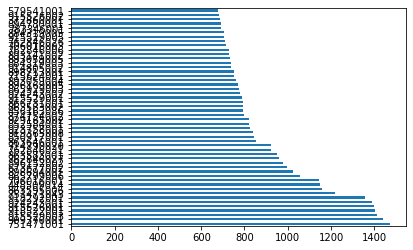

In [186]:
df['article_id'].value_counts()[:50].plot(kind='barh')

In [187]:
cust_counts = df['article_id'].value_counts()
cust_list = cust_counts[cust_counts > min_count].index.tolist()
df = df[df['article_id'].isin(cust_list)]

### v. Balancing the Data <a class="anchor" id="bd-bullet"></a>

[TOP ↑](#top)

Next, we need to balance our data so that none of the articles dominate the predictions.

We can define a function to do this for us. This particular function is not my own work, I have taken it as a self-contained unit from *rensdimmendaal.com*.

In [188]:
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )

df = downsample(df, "article_id")

<AxesSubplot:>

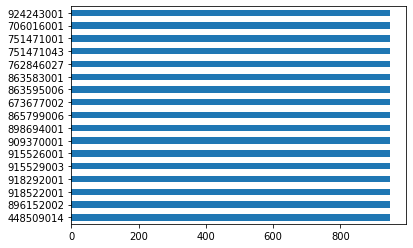

In [189]:
df['article_id'].value_counts()[:50].plot(kind='barh')

In [190]:
df.head()

,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,fashion_news_frequency,club_member_status_ACTIVE,club_member_status_INACTIVE,age_binned_young,age_binned_old,fave_colour_-1,fave_colour_1,fave_colour_2,fave_colour_3,fave_colour_4,fave_colour_5,fave_colour_6,fave_colour_7,fave_colour_8,fave_colour_9,fave_colour_10,fave_colour_11,fave_colour_12,fave_colour_13,fave_colour_14,fave_colour_15,fave_colour_17,fave_colour_19,fave_colour_20,fave_colour_21,fave_colour_22,fave_colour_23,fave_colour_30,fave_colour_31,fave_colour_32,fave_colour_33,fave_colour_40,fave_colour_41,fave_colour_42,fave_colour_43,fave_colour_50,fave_colour_51,fave_colour_52,fave_colour_53,fave_colour_60,fave_colour_61,fave_colour_62,fave_colour_63,fave_colour_70,fave_colour_71,fave_colour_72,fave_colour_73,fave_colour_80,fave_colour_81,fave_colour_82,fave_colour_83,fave_colour_90,fave_colour_91,fave_colour_92,fave_colour_93,2nd_fave_colour_-1.0,2nd_fave_colour_1.0,2nd_fave_colour_2.0,2nd_fave_colour_3.0,2nd_fave_colour_4.0,2nd_fave_colour_5.0,2nd_fave_colour_6.0,2nd_fave_colour_7.0,2nd_fave_colour_8.0,2nd_fave_colour_9.0,2nd_fave_colour_10.0,2nd_fave_colour_11.0,2nd_fave_colour_12.0,2nd_fave_colour_13.0,2nd_fave_colour_14.0,2nd_fave_colour_15.0,2nd_fave_colour_17.0,2nd_fave_colour_19.0,2nd_fave_colour_20.0,2nd_fave_colour_21.0,2nd_fave_colour_22.0,2nd_fave_colour_23.0,2nd_fave_colour_30.0,2nd_fave_colour_31.0,2nd_fave_colour_32.0,2nd_fave_colour_33.0,2nd_fave_colour_40.0,2nd_fave_colour_41.0,2nd_fave_colour_42.0,2nd_fave_colour_43.0,2nd_fave_colour_50.0,2nd_fave_colour_51.0,2nd_fave_colour_52.0,2nd_fave_colour_53.0,2nd_fave_colour_60.0,2nd_fave_colour_61.0,2nd_fave_colour_62.0,2nd_fave_colour_63.0,2nd_fave_colour_70.0,2nd_fave_colour_71.0,2nd_fave_colour_72.0,2nd_fave_colour_73.0,2nd_fave_colour_80.0,2nd_fave_colour_81.0,2nd_fave_colour_82.0,2nd_fave_colour_83.0,2nd_fave_colour_90.0,2nd_fave_colour_91.0,2nd_fave_colour_92.0,2nd_fave_colour_93.0,2nd_fave_colour_Unknown,fave_pattern_-1,fave_pattern_1010001,fave_pattern_1010002,fave_pattern_1010003,fave_pattern_1010004,fave_pattern_1010005,fave_pattern_1010006,fave_pattern_1010007,fave_pattern_1010008,fave_pattern_1010009,fave_pattern_1010010,fave_pattern_1010011,fave_pattern_1010012,fave_pattern_1010013,fave_pattern_1010014,fave_pattern_1010015,fave_pattern_1010016,fave_pattern_1010017,fave_pattern_1010018,fave_pattern_1010019,fave_pattern_1010020,fave_pattern_1010021,fave_pattern_1010022,fave_pattern_1010023,fave_pattern_1010024,fave_pattern_1010025,fave_pattern_1010026,fave_pattern_1010027,fav

In [191]:
fulltable = df.copy()

In [192]:
fulltable.head()

,1201,1202,1212,1222,1241,1244,1310,1313,1322,1334,1336,1338,1339,1343,1344,1352,1410,1414,1422,1444,1447,1510,1515,1522,1543,1545,1547,1610,1612,1616,1620,1626,1636,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1652,1660,1666,1670,1676,1686,1710,1717,1722,1723,1727,1743,1744,1745,1747,1752,1772,1773,1774,1778,1779,1909,1912,1919,1920,1926,1929,1939,1941,1948,1949,2031,2032,2033,2034,2035,2080,2930,2932,2950,3000,3030,3040,3080,3090,3209,3409,3419,3420,3439,3509,3510,3519,3527,3528,3529,3608,3610,3611,3629,3630,3705,3708,3709,3710,3828,3929,3931,3932,3936,3937,3938,3939,3941,3943,3944,3945,3946,3948,4020,4030,4090,4091,4092,4210,4211,4212,4213,4214,4215,4216,4220,4221,4222,4224,4225,4242,4310,4311,4312,4313,4314,4317,4320,4321,4322,4323,4327,4342,4343,4344,4345,4920,5131,5231,5252,5262,5283,5454,5555,5626,5627,5631,5641,5656,5658,5672,5673,5679,5683,5686,5687,5690,5731,5741,5767,5777,5783,5787,5828,5831,5832,5833,5848,5858,5868,5878,5882,5883,5884,5888,5950,5952,5956,5957,5958,5959,5960,5961,5962,5963,5999,6280,6281,6283,6512,6515,6525,6526,6541,6545,6546,6550,6555,6557,6561,6563,6564,6565,7020,7050,7188,7388,7389,7510,7520,7530,7613,7616,7617,7618,7648,7655,7656,7657,7658,7659,7668,7757,7812,7814,7819,7848,7852,7854,7857,7912,7917,7920,7921,7922,7930,7931,7932,7952,7956,7987,7988,7989,8030,8090,8310,8316,8394,8396,8397,8398,8558,8559,8560,8563,8564,8615,8616,8617,8713,8716,8717,8718,8748,8755,8756,8757,8758,8768,8812,8815,8852,8888,8917,8956,9020,9984,9985,9986,9989,FN,fashion_news_frequency,club_member_status_ACTIVE,club_member_status_INACTIVE,age_binned_young,age_binned_old,fave_colour_-1,fave_colour_1,fave_colour_2,fave_colour_3,fave_colour_4,fave_colour_5,fave_colour_6,fave_colour_7,fave_colour_8,fave_colour_9,fave_colour_10,fave_colour_11,fave_colour_12,fave_colour_13,fave_colour_14,fave_colour_15,fave_colour_17,fave_colour_19,fave_colour_20,fave_colour_21,fave_colour_22,fave_colour_23,fave_colour_30,fave_colour_31,fave_colour_32,fave_colour_33,fave_colour_40,fave_colour_41,fave_colour_42,fave_colour_43,fave_colour_50,fave_colour_51,fave_colour_52,fave_colour_53,fave_colour_60,fave_colour_61,fave_colour_62,fave_colour_63,fave_colour_70,fave_colour_71,fave_colour_72,fave_colour_73,fave_colour_80,fave_colour_81,fave_colour_82,fave_colour_83,fave_colour_90,fave_colour_91,fave_colour_92,fave_colour_93,2nd_fave_colour_-1.0,2nd_fave_colour_1.0,2nd_fave_colour_2.0,2nd_fave_colour_3.0,2nd_fave_colour_4.0,2nd_fave_colour_5.0,2nd_fave_colour_6.0,2nd_fave_colour_7.0,2nd_fave_colour_8.0,2nd_fave_colour_9.0,2nd_fave_colour_10.0,2nd_fave_colour_11.0,2nd_fave_colour_12.0,2nd_fave_colour_13.0,2nd_fave_colour_14.0,2nd_fave_colour_15.0,2nd_fave_colour_17.0,2nd_fave_colour_19.0,2nd_fave_colour_20.0,2nd_fave_colour_21.0,2nd_fave_colour_22.0,2nd_fave_colour_23.0,2nd_fave_colour_30.0,2nd_fave_colour_31.0,2nd_fave_colour_32.0,2nd_fave_colour_33.0,2nd_fave_colour_40.0,2nd_fave_colour_41.0,2nd_fave_colour_42.0,2nd_fave_colour_43.0,2nd_fave_colour_50.0,2nd_fave_colour_51.0,2nd_fave_colour_52.0,2nd_fave_colour_53.0,2nd_fave_colour_60.0,2nd_fave_colour_61.0,2nd_fave_colour_62.0,2nd_fave_colour_63.0,2nd_fave_colour_70.0,2nd_fave_colour_71.0,2nd_fave_colour_72.0,2nd_fave_colour_73.0,2nd_fave_colour_80.0,2nd_fave_colour_81.0,2nd_fave_colour_82.0,2nd_fave_colour_83.0,2nd_fave_colour_90.0,2nd_fave_colour_91.0,2nd_fave_colour_92.0,2nd_fave_colour_93.0,2nd_fave_colour_Unknown,fave_pattern_-1,fave_pattern_1010001,fave_pattern_1010002,fave_pattern_1010003,fave_pattern_1010004,fave_pattern_1010005,fave_pattern_1010006,fave_pattern_1010007,fave_pattern_1010008,fave_pattern_1010009,fave_pattern_1010010,fave_pattern_1010011,fave_pattern_1010012,fave_pattern_1010013,fave_pattern_1010014,fave_pattern_1010015,fave_pattern_1010016,fave_pattern_1010017,fave_pattern_1010018,fave_pattern_1010019,fave_pattern_1010020,fave_pattern_1010021,fave_pattern_1010022,fave_pattern_1010023,fave_pattern_1010024,fave_pattern_1010025,fave_pattern_1010026,fave_pattern_1010027,fav

In [193]:
len(df)

16116

In [194]:
df.shape

(16116, 436)

In [195]:
#df = df.sample(frac=0.7, replace=False, random_state=1)
df.shape

(16116, 436)

We can print the number of classes given our chosen *min_count*, which corresponds to the number of articles we will choose from when predicting for each customer. In this case, there are 17.

In [196]:
n_classes = df["article_id"].nunique()
print(n_classes)

17


### vi. Advanced Feature Selection <a class="anchor" id="afs-bullet"></a>

[TOP ↑](#top)

Split the Data

Next, we'd like to do some feature selection, particularly given that there quite a number of features emerged from the one-hot-encoding. Initially, I had wanted to automate this process, but I ran out of time. 

In [197]:
y = df.pop('article_id').values 
X = df.values         

type(X),type(y)

(numpy.ndarray, numpy.ndarray)

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/3)

We can use sklearn's native modules to output the information gain for each feature.

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mnb = GaussianNB()

feature_names = df.columns
mi = dict()

i_scores = mutual_info_classif(X_train, y_train)

for i,j in zip(feature_names,i_scores):
    mi[i]=j
 
df_i = pd.DataFrame.from_dict(mi,orient='index',columns=['I-Gain'])
df_i.sort_values(by=['I-Gain'],ascending=False,inplace=True)
df_i.head(15)

,I-Gain
1941,0.031637
1747,0.031366
3510,0.026059
age_binned_young,0.025480
3090,0.022793
fave_colour_15,0.022680
1322,0.021885
3080,0.021679
fave_colour_9,0.020383
1626,0.020215


We can plot the information gain against accuracy. This process takes a little time.

In [ ]:
acc_scores = []
for kk in range(1, X.shape[1]+1):
    FS_trans = SelectKBest(mutual_info_classif, k=kk).fit(X_train, y_train)
    X_tR_new = FS_trans.transform(X_train)
    X_tS_new = FS_trans.transform(X_test)
    hm_NB = mnb.fit(X_tR_new, y_train)
    y_dash = hm_NB.predict(X_tS_new)
    acc = accuracy_score(y_test, y_dash)
    acc_scores.append(acc)

df_i['Accuracy'] = acc_scores
df_i.head(10)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

%matplotlib inline

n = len(df_i.index)
rr = range(1,n)
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.bar(df_i.index, df_i["I-Gain"], label='I-Gain',width=.35)
ax2.plot(df_i.index, df_i["Accuracy"], color='red', label='Accuracy')

ax.xaxis.set_major_locator(mticker.FixedLocator(range(0,n)))

ax.set_xticklabels(list(df_i.index), rotation = 90)

ax.set_xlabel('Features')
ax.set_ylabel('I-Gain')
ax2.set_ylabel('Accuracy')
ax.legend()

plt.show()

We can also run a forward sequential wrapper using 10-fold cross-validation.

In [ ]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
knn = KNeighborsClassifier(n_neighbors=4)

sfs_forward = SFS(knn, 
                  k_features=19, 
                  forward=True, 
                  floating=False, 
                  verbose=1,
                  scoring='accuracy',
                  cv=10, n_jobs = -1)

sfs_forward = sfs_forward.fit(X, y, 
                              custom_feature_names=feature_names)

We can then plot the accuracy against the number of features.

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_forward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev')

plt.ylim([0, 0.1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
print(sfs_forward.k_feature_names_)

In [ ]:
fulltable.head()

I have chosen to keep only the top eleven features, based on the above cosniderations, namely "age_binned_old", "age_binned_young", alongside standardised purchases in eight departments: 1616, 3090, 1941, 1747, 5626, 1322, 1201, 1626.

In [ ]:
fulltable = fulltable[["age_binned_old", "age_binned_young", 1616, 3090, 1941, 1747, 5626, 1322, 1201, 1626, "article_id"]]
fulltable.head()

In [ ]:
fulltable.shape

Next, we must split the new dataframe for training and testing.

In [ ]:
y = fulltable.pop('article_id').values 
X = fulltable.values         

type(X),type(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/3)

### vii. kNN Classification <a class="anchor" id="knn-bullet"></a>

[TOP ↑](#top)

I have opted to use a kNN classifier as I'm attempting to find similar customers and to make personalised article recommendations based on this similarity. 

First, I'd like to make sure that the test and train arrays are in the correct format.

In [ ]:
print(y_test)

In [ ]:
y_test.dtype

In [ ]:
print(X_test)

In [ ]:
len(X_test)

In [ ]:
len(y_test)

In [ ]:
n_classes = len(np.unique(y_test))
print(n_classes)

#### a. Standardisation <a class="anchor" id="std-bullet"></a>

[TOP ↑](#top)

We will need to standardise the numerical data prior to passing it to the kNN algorithm, to avoid one feature dominating over another.

In [ ]:
Scal = StandardScaler().fit(X_train)
X_trainS = Scal.transform(X_train)
X_testS = Scal.transform(X_test)

#### b. Model Grid Search <a class="anchor" id="mgs-bullet"></a>

[TOP ↑](#top)

Next, we want to explore hyperparameter space to determine the best combination for classification.

In [ ]:
param_grid = {'n_neighbors':[1,3,5,10], 
              'metric':['manhattan','euclidean'],
             'weights':['uniform','distance']}

In [ ]:
knn = KNeighborsClassifier()
knn_gs = GridSearchCV(knn,param_grid,cv=10,  
                      verbose = 1, n_jobs = -1)
knn_gs = knn_gs.fit(X_trainS,y_train)

#### c. Model Evaluation <a class="anchor" id="meval-bullet"></a>

[TOP ↑](#top)

In [ ]:
y_pred_gs = knn_gs.predict(X_testS)
print("Accuracy: {0:4.2f}".format(accuracy_score(y_test,y_pred_gs)))
confusion_matrix(y_test, y_pred_gs)

We can check what the classifier is being used.

In [ ]:
knn_gs

We can also check the parameters.

In [ ]:
knn_gs.best_params_

I will automatically asssign the best parameters to the kNN we use for classification.

In [ ]:
m = knn_gs.best_params_["metric"]
n = knn_gs.best_params_["n_neighbors"]
w = knn_gs.best_params_["weights"]

In [ ]:
kNN2 = KNeighborsClassifier(metric=m, n_neighbors=n, weights=w) 
kNN2.fit(X_train,y_train)
y_dash = kNN2.predict(X_test)

Let's remind ourselves of the number of labels, the number of articles we're actually predicting.

In [ ]:
print(kNN2.classes_)

In [ ]:
print(len(kNN2.classes_))

We need to assign the probabilities for each article to a variable so that we can later predict the top 12, as opposed to simple singular classification.

In [ ]:
y_probs = kNN2.predict_proba(X_test)

In [ ]:
print(y_probs)

In [ ]:
print(y_dash)

In [ ]:
y_dash.dtype

In [ ]:
len(y_dash)

We can print the accuracy, and the confusion matrix.

In [ ]:
acc = accuracy_score(y_test, y_dash)
print("Accuracy: {0:.2f}".format(acc)) 
confusion = confusion_matrix(y_test, y_dash)
print("Confusion matrix:\n{}".format(confusion)) 

In [ ]:
report = classification_report(y_test, y_dash)
print("Report:\n{}".format(report)) 

These values aren't fantastic, but they're the best ones I've yet gotten. The F1 measure is the harmonic mean of the precision and recall, so is a good guide.

I'd also like to perform cross validation, as this provides a better evaluation of the accuracy at the deployment stage.

In [ ]:
kNN_scores = cross_val_score(kNN2, X, y, cv=5)
print("5x CV Accuracy kNNs: {0:.2f}".format(kNN_scores.mean())) 
kNN_scores

#### d. Decision Tree  <a class="anchor" id="dt-bullet"></a>

[TOP ↑](#top)

I would like to use a simple Decision Tree on the same data, just for comparison purposes.

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
y_dash_tree = tree.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_dash_tree)
print("Accuracy: {0:.2f}".format(acc)) 
confusion = confusion_matrix(y_test, y_dash_tree)
print("Confusion matrix:\n{}".format(confusion)) 

### viii. Predictions <a class="anchor" id="pred-bullet"></a>

[TOP ↑](#top)

We need to write a function which will take the classification probabilities from the model and output the indices of the top 12 articles. This can be achieved using the *argsort()* function. This is my own function.

In [ ]:
def take_top_twelve(y_probs):
    sortedindices = np.argsort(-y_probs)
    slicedsortedindices = sortedindices[:12]
    return slicedsortedindices

Next, armed with our function, we need to create for loop which will create a list of the top 12 articles for each customer, convert the article_ids to strings, concatenate the 12 articles into a single long string and then convert this to a dataframe called **predictions**.

In [ ]:
rows = []

for x in range(0, len(y_probs)):
    top12indices = take_top_twelve(y_probs[x])
    predicted_labels = kNN2.classes_[top12indices]
    list_top12 = predicted_labels.tolist()
    top12 = [str(x) for x in list_top12]
    top12 = ["0" + el for el in top12]
    top_12 = ' '.join(top12)
    rows.append([customers_for_prediction[x], top_12])
    
predictions = pd.DataFrame(rows, columns=["customer_id", "new_prediction"])

In [ ]:
predictions.head()

We don't want to join these predictions to the a test submission file.

In [ ]:
submission = sample_submission_df.merge(predictions, on="customer_id", how='left')

In [ ]:
submission = submission.drop(['prediction'], axis=1)

In [ ]:
submission = submission.rename(columns={'new_prediction':'prediction'})

In [ ]:
submission.head()

In [ ]:
submission.isnull().sum()

In [ ]:
len(submission)

In [ ]:
number_of_customers_for_whom_we_have_predictions = len(submission) - submission["prediction"].isnull().sum()
print(number_of_customers_for_whom_we_have_predictions)

### ix. The 12 Top Articles <a class="anchor" id="twelve-bullet"></a>

[TOP ↑](#top)

We need to choose the top 12 articles in the final week of the prior transactions to make a prediction for those customers not included in our model, for whom we have no data.

In [ ]:
top_12_items = transactions_prior[transactions_prior['t_dat'] > '2020-08-21'].groupby('article_id')['customer_id'].nunique().sort_values(ascending=False).head(12).index.tolist()

In [ ]:
top_12_items

In [ ]:
top_12_items = [str(x) for x in top_12_items]
top_12_items = ["0" + el for el in top_12_items]
top_12 = ' '.join(top_12_items)

In [ ]:
submission = submission.fillna(top_12)

In [ ]:
submission.isnull().sum()

In [ ]:
submission.head()

In [ ]:
submission.tail()

In [ ]:
submission.head()

In [ ]:
submission.shape

In [ ]:
#submission.to_csv('submission.csv', index=False)

In [ ]:
articles_predicted = submission['prediction'].str.split('\s').to_list()

In [ ]:
articles_predicted[0:3]

These need to be converted to integer type.

In [ ]:
for e in articles_predicted:
    for i in e:
        i = int(i)

In [ ]:
articles_predicted[0:3]

In [ ]:
articles_predicted = [[int(j) for j in i] for i in articles_predicted]

In [ ]:
articles_predicted[0:3]

### x. MAP@12 Evaluation <a class="anchor" id="eval-bullet"></a>

[TOP ↑](#top)

Next, we need to evaluate our predictions according to the metric used in the Kaggle competition. This is the Mean Average Precision at 12 (MAP@12), and gives a score based on how many predictions we got correct.

The two functions below, one calculating the Average Precision at k, apk(), and the other calling this function to calculate the Mean Average Precision at k, mapk(), were taken as a unit from *github.com/benhamner*. I wanted to re-code these in my own way, but I've ran out of time.

In [ ]:
#This function computes the average precision at k between two lists.

def apk(actual, predicted, k=12):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

#This function computes the mean average precision at k between two lists of lists.

def mapk(actual, predicted, k=12):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In order to use these function, we need a list of articles (also a list) bought by each customer.

In [ ]:
transactions_september.head()

In [ ]:
articles_bought = transactions_september.groupby("customer_id").agg(list)["article_id"].to_list()

In [ ]:
print(articles_bought[0:4])

I need to create a "conglomerate" dataframe which includes all the customers, not just those in the transactions data.

In [ ]:
conglomerate = sample_submission_df.merge(transactions_september, how='outer', on='customer_id')
conglomerate = conglomerate.fillna(0)
conglomerate["article_id"] = conglomerate["article_id"].astype(int)

In [ ]:
conglomerate.head()

In [ ]:
articles_actually_bought = conglomerate.groupby("customer_id").agg(list)["article_id"].to_list()

In [ ]:
articles_actually_bought[0:10]

In [ ]:
len(articles_actually_bought)

In [ ]:
submission.head()

Finally, I can use the mapk() function to compare the two lists of lists, one for predicted articles and one for the articles actually bought, and output the MAP@12.

In [ ]:
map12 = mapk(articles_predicted, articles_actually_bought, k=12)

In [ ]:
print(map12)

### xi. Deployment <a class="anchor" id="dep-bullet"></a>

[TOP ↑](#top)

The final stage in any machine learning project is deployment. We will use our model which has been trained and evaluated to make predictions for all customers for whom we have data.

We need first to get predictions for all the customers in the prior transactions data, of which there are 1,344,743. This is *less* than the 1,371,980 customers listed in **customers_df**, a difference of 27,237. We will deal with predictions for these customers later on.

In [ ]:
all_customers_in_prior_transactions_df

We can pull out the list of customers contained in the prior transactions for deployment.

In [ ]:
all_customers_in_prior_transactions = all_customers_in_prior_transactions_df['customer_id']

In [ ]:
all_customers_in_prior_transactions_df = all_customers_in_prior_transactions_df[["age_binned_old", "age_binned_young", 1616, 3090, 1941, 1747, 5626, 1322, 1201, 1626]]

Next, we can drop the **customers_id** for deployment.

In [ ]:
all_customers_in_prior_transactions_df.head()

In [ ]:
all_customers_in_prior_transactions_df.head()

We need to apply the exact same scaling to the full data as we did to the training data.

In [ ]:
X_deployment = Scal.transform(all_customers_in_prior_transactions_df)

In [ ]:
type(X_deployment)

In [ ]:
print(X_deployment[0:2, 1:4])

Next, we can make predictions for all of the customers. This process takes about 10 minutes.

In [ ]:
%time y_pred = kNN2.predict_proba(X_deployment)

Next, we can append the top 12 predictions for each customer in the prior transactions.

In [ ]:
rows = []

for x in range(0, len(y_pred)):
    top12indices = take_top_twelve(y_pred[x])
    predicted_labels = kNN2.classes_[top12indices]
    list_top12 = predicted_labels.tolist()
    top12 = [str(x) for x in list_top12]
    top12 = ["0" + el for el in top12]
    top_12 = ' '.join(top12)
    rows.append([all_customers_in_prior_transactions[x], top_12])
    
deployment_predictions = pd.DataFrame(rows, columns=["customer_id", "new_prediction"])

In [ ]:
deployment_predictions.head()

In order to create the submission dataframe, we merge the predictions with the original sample submission, using a left join to preserve those rows belonging to customers for whom we do not have any predictions.

In [ ]:
submission2 = sample_submission_df.merge(deployment_predictions, on="customer_id", how='left')

In [ ]:
submission2 = submission2.drop(['prediction'], axis=1)

In [ ]:
submission2 = submission2.rename(columns={'new_prediction':'prediction'})

In [ ]:
submission2.head()

In [ ]:
submission2.isnull().sum()

In [ ]:
len(submission2)

Next, we can check to see the number of customers for whom we have predictions. In the case of those for whom we do not have predictions, because they have no information in the historical transactions data, we can simply predict the top 12 articles.

In [ ]:
number_of_customers_for_whom_we_have_predictions = len(submission2) - submission2["prediction"].isnull().sum()
print(number_of_customers_for_whom_we_have_predictions)

In [ ]:
top_12_items = transactions_df[transactions_df['t_dat'] > '2020-09-15'].groupby('article_id')['customer_id'].nunique().sort_values(ascending=False).head(12).index.tolist()

In [ ]:
top_12_items

In [ ]:
top_12_items = [str(x) for x in top_12_items]
top_12_items = ["0" + el for el in top_12_items]
top_12 = ' '.join(top_12_items)

In [ ]:
submission2 = submission2.fillna(top_12)

In [ ]:
submission2.isnull().sum()

In [ ]:
submission2.head()

Finally, we can export our submission dataframe to a CSV file.

In [ ]:
submission2.to_csv('submission_final.csv', index=False)

## Conclusion <a class="anchor" id="conc-bullet"></a>

[TOP ↑](#top)

This was an exceedingly difficult challenge, but very enjoyable. I didn't think my model would ever be capable of predicting anything better than the baseline. This was down to constraints on the granularity of the data I was providing to the model on account of memory issues. However, with a judicious choice of features aided entirely by analysis of the information gain, the hybrid model - inclusive of historical coarse grain transaction data and some customer information - was able to beat the baseline prediction. In the future, I would build a model trained on data at a higher grain using a more powerful machine, perhaps aided by principal component analysis. I don't think I'll be winning any money with this one.

## References <a class="anchor" id="references-bullet"></a>

[TOP ↑](#top)

https://rensdimmendaal.com/data-science/undersampling-with-pandas/

https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py

https://towardsdatascience.com/machine-learning-with-datetime-feature-engineering-predicting-healthcare-appointment-no-shows-5e4ca3a85f96

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/307517

https://www.kaggle.com/code/andreiflorea04/h-m-eda

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/308919

https://www.kaggle.com/code/andreiflorea04/h-m-solution

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/316903

https://www.kaggle.com/code/julian3833/h-m-content-based-12-most-popular-items-0-007

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/309220

https://www.kaggle.com/code/datark1/detailed-eda-understanding-h-m-data

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/307448

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/307288

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/308931

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/308919

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/306558

https://www.kaggle.com/code/aerdem4/h-m-pure-pytorch-baseline/notebook

https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/312653